# BirdCLEF 2023 🐦
> Identify bird calls in soundscapes

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/44224/logos/header.png?t=2023-03-06-18-30-53">

# Methodology 🎯

In this notebook, we will explore how to identify bird calls using TensorFlow. Specifically, this notebook will cover:

* How to use tf.data for audio processing tasks and reading .ogg files in TensorFlow
* How to extract spectrogram features from raw audio on TPU/GPU, which reduces CPU bottleneck significantly, speeding up the process by ~$4 \times$ on **P100 GPU** compared to the [previous notebook](https://www.kaggle.com/code/awsaf49/birdclef23-effnet-fsr-cutmixup-train).
* Unlike the previous tutorial, this notebook will perform spectrogram augmentation such as `TimeFreqMask` and `Normalization` on **GPU/TPU** and perform `CutMix` and `MixUp` with audio data on **CPU**.
* This notebook demonstrates how **pre-training on the BirdCLEF - 2020, 2021, 2022 & Xeno-Canto Extend** dataset can improve transfer learning performance. CNN backbones, like `EfficientNet`, struggle with spectrogram data even with ImageNet pre-trained weights as they are not fimilar with audio data. Pre-training on an audio dataset, like BirdCLEF, can mitigate this issue and can yield a ~$5\%$ improvement in local validation and ~$2\%$ improvement in leaderboard.
* This notebook is compatible with both GPU, TPU, and the newly launched TPU-VM device is automatically selected, so you won't have to do anything to allocate the device.

# Notebooks 📓

* Pretraining is All you Need
    * Train: [BirdCLEF23: Pretraining is All you Need [Train]](https://www.kaggle.com/awsaf49/birdclef23-pretraining-is-all-you-need-train/)
    * Infer: [BirdCLEF23: Pretraining is All you Need [Infer]](https://www.kaggle.com/awsaf49/birdclef23-pretraining-is-all-you-need-infer/)
    
    
* EffNet + FSR + CutMixUp
    * Train: [BirdCLEF23: EffNet + FSR + CutMixUp [Train]](https://www.kaggle.com/awsaf49/birdclef23-effnet-fsr-cutmixup-train/)
    * Infer: [BirdCLEF23: EffNet + FSR + CutMixUp [Infer]](https://www.kaggle.com/awsaf49/birdclef23-effnet-fsr-cutmixup-infer/)


# Update 🔄
* `v3`: BirdCLEF 2022 & Xeno-Canto Extend data added.
* `v9`: Libraries have been updated according to new TPU-VM environment. Check version cell for updates versions. Also it reduces time by avoiding installation of TF 2.9 manually.

# Install Libraries 🛠

## For `TPU VM v3-8`

Usually these libraries come pre-installed for other accelerators but fo tpu-vm we need to install them manually. If you want to use rather remote-TPU or GPU or CPU, then comment out the following cell.


In [2]:
# # Tensorflow for tpu-vm
# !pip install -q /lib/wheels/tensorflow-2.9.1-cp38-cp38-linux_x86_64.whl

# # Tensorflow utilities
!pip install -q tensorflow-addons
!pip install -q tensorflow-probability
!pip install -q tensorflow-io

# # Other utilies not available on tpu-vm
!pip install -q opencv-python-headless
!pip install -q librosa
!pip install -q scikit-learn

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
elegy 0.8.6 requires wandb<0.13.0,>=0.12.10, but you have wandb 0.14.1 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


## Libraries for Model & Layers
In this notebook to make the code as compact as possible `tensorflow_extra` library. This library contains all the necessary layers that will do ops like `MelSpectrogram`, `TimeFreqMask`, `ZScoreMinMax` on GPU/TPU. You are welcome to check the [source code](https://github.com/awsaf49/tensorflow_extra).
> **Note**: `tensorflow_extra` library is not any offical library  from TensorFlow rather a custom library built by me to ease the workflow.

Additionally, this notebook will use [this library](https://github.com/awsaf49/efficientnet-spec) for `EfficientNet` models with **Filter Stride Reduction (FSR)**.

In [3]:
# For Spectrogram, SpecAug layers
!pip install -qU tensorflow_extra --no-deps

# efficientnet with filter stride reduction (FSR)
!pip install -qU git+https://github.com/awsaf49/efficientnet-spec

In [6]:
!pip install tensorflow==2.12 tensorflow-addons[tensorflow]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow-addons[tensorflow] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 12.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 48.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 52.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 2.0 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: wrapt
    Found existing installation: wra

# Import Libraries 📚

In [8]:
import os
# os.environ['TPU_LOG_DIR'] = '/kaggle/working'

import pandas as pd
pd.options.mode.chained_assignment = None # avoids assignment warning
import numpy as np
import random
from glob import glob
from tqdm import tqdm
tqdm.pandas()  # enable progress bars in pandas operations
import gc

import librosa
import sklearn
import json

# Import for visualization
import matplotlib as mpl
cmap = mpl.cm.get_cmap('coolwarm')
import matplotlib.pyplot as plt
import librosa.display as lid
import IPython.display as ipd
import cv2

# Import tensorflow
import tensorflow as tf
# Set logging level to avoid unnecessary messages
tf.get_logger().setLevel('ERROR')
# Set autograph verbosity to avoid unnecessary messages
tf.autograph.set_verbosity(0)
# Enable xla for speed up
# tf.config.optimizer.set_jit(False) #  throws error for time-freq-mask

# Import required tensorflow modules
import tensorflow_io as tfio
import tensorflow_addons as tfa
# import tensorflow_probability as tfp
import tensorflow.keras.backend as K

/tmp/ipykernel_228/2650710021.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


## Library Version

In [10]:
print('np:', np.__version__)
print('pd:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('librosa:', librosa.__version__)
print('tf:', tf.__version__)
# print('tfp:', tfp.__version__)
print('tfa:', tfa.__version__)
print('tfio:', tfio.__version__)

np: 1.24.3
pd: 2.1.3
sklearn: 1.3.2
librosa: 0.10.1
tf: 2.13.0
tfa: 0.19.0
tfio: 0.32.0


# Configuration ⚙️

In [5]:
class CFG:
    # Debugging
    debug = False
    
    # Verbosity level
    verbose = 0
    
    # Plot training history
    training_plot = True
    
    # Weights and Biases logging
    wandb = True
    competition   = 'birdclef-2023' 
    
    # Experiment name and comment
    exp_name = 'birdclef-pretrain-v3'
    comment = 'EfficientNetB1|No-FSR|t=10s|128x384|cutmix'
    
    # Device and random seed
    device = 'TPU-VM'
    seed = 42
    

    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 32
    upsample_thr = 50 # min sample of each class (upsample)
    cv_filter = True # always keeps low sample data in train
    
    # Audio duration, sample rate, and length
    duration = 10 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    normalize = True
    
    # Inference batch size, test time augmentation, and drop remainder
    infer_bs = 2
    tta = 1
    drop_remainder = True
    
    # Number of epochs, model name, and number of folds
    epochs = 25
    model_name = 'EfficientNetB1'
    fsr = False # reduce stride of stem block
    num_fold = 5
    
    # Selected folds for training and evaluation
    selected_folds = [0]

    # Pretraining, neck features, and final activation function
    pretrain = 'imagenet'
    neck_features = 0
    final_act = 'softmax'
    
    # Learning rate, optimizer, and scheduler
    lr = 1e-3
    scheduler = 'cos'
    optimizer = 'Adam' # AdamW, Adam
    
    # Loss function and label smoothing
    loss = 'CCE' # BCE, CCE
    label_smoothing = 0.05 # label smoothing
    
    # Data augmentation parameters
    augment=True
    
    # Time Freq masking
    freq_mask_prob=0.50
    num_freq_masks=1
    freq_mask_param=10
    time_mask_prob=0.50
    num_time_masks=2
    time_mask_param=25

    # Audio Augmentation Settings
    audio_augment_prob = 0.5
    
    mixup_prob = 0.65
    mixup_alpha = 0.5
    
    cutmix_prob = 0.65
    cutmix_alpha = 2.5
    
    timeshift_prob = 0.0
    
    gn_prob = 0.35

    # Class Labels for BirdCLEF 23
    class_names = sorted(os.listdir('/kaggle/input/birdclef-2023/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}
    
    # Class Labels for BirdCLEF 21 & 22
    class_names2 = sorted(set(os.listdir('/kaggle/input/birdclef-2021/train_short_audio/')
                       +os.listdir('/kaggle/input/birdclef-2022/train_audio/')
                       +os.listdir('/kaggle/input/birdsong-recognition/train_audio/')))
    num_classes2 = len(class_names2)
    class_labels2 = list(range(num_classes2))
    label2name2 = dict(zip(class_labels2, class_names2))
    name2label2 = {v:k for k,v in label2name2.items()}

    # Training Settings
    target_col = ['target']
    tab_cols = ['filename']
    monitor = 'auc'

# Reproducibility ♻️
Sets value for random seed to produce similar result in each run.

In [6]:
tf.keras.utils.set_random_seed(CFG.seed)

# WandB 🪄
<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

To track model's training I'll be using **Weights & Biases** tool. Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management. Specifically for this notebook, we can do error analysis to check in which audio files models are struggling as we can also log **audio** file in WandB.

In [7]:
# Import wandb library for logging and tracking experiments
import wandb

# Try to get the API key from Kaggle secrets
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    # Login to wandb with the API key
    wandb.login(key=api_key)
    # Set anonymous mode to None
    anonymous = None
except:
    # If Kaggle secrets are not available, set anonymous mode to 'must'
    anonymous = 'must'
    # Login to wandb anonymously and relogin if needed
    wandb.login(anonymous=anonymous, relogin=True)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Set Up Device  📱
Following codes automatically detects hardware(tpu or tpu-vm or gpu). 

In [8]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    # Check TPU category
    tpu = 'local' if CFG.device=='TPU-VM' else None
    try:
        # Connect to TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu) 
        # Set TPU strategy
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on {CFG.device}', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device, tpu

In [9]:
# Initialize GPU/TPU/TPU-VM
strategy, CFG.device, tpu = get_device()
CFG.replicas = strategy.num_replicas_in_sync

> Running on TPU-VM  | Num of TPUs:  8


# Dataset Path 📁
`TPU v3-8` aka `Remote-TPU` requires GCS path for training. Thankfully kaggle provides us GCS path for each dataset. Following codes automatically uses GCS path if remote TPU is used as device.

In [10]:
BASE_PATH0 = '/kaggle/input/birdsong-recognition'
BASE_PATH1 = '/kaggle/input/birdclef-2021'
BASE_PATH2 = '/kaggle/input/birdclef-2022'
BASE_PATH3 = '/kaggle/input/birdclef-2023'
BASE_PATH4 = '/kaggle/input/xeno-canto-bird-recordings-extended-a-m'
BASE_PATH5 = '/kaggle/input/xeno-canto-bird-recordings-extended-n-z'

if CFG.device=="TPU":
    from kaggle_datasets import KaggleDatasets
    GCS_PATH0 = KaggleDatasets().get_gcs_path(BASE_PATH0.split('/')[-1])
    GCS_PATH1 = KaggleDatasets().get_gcs_path(BASE_PATH1.split('/')[-1])
    GCS_PATH2 = KaggleDatasets().get_gcs_path(BASE_PATH2.split('/')[-1])
    GCS_PATH3 = KaggleDatasets().get_gcs_path(BASE_PATH3.split('/')[-1])
    GCS_PATH4 = KaggleDatasets().get_gcs_path(BASE_PATH4.split('/')[-1])
    GCS_PATH5 = KaggleDatasets().get_gcs_path(BASE_PATH5.split('/')[-1])
else:
    GCS_PATH0 = BASE_PATH0
    GCS_PATH1 = BASE_PATH1
    GCS_PATH2 = BASE_PATH2
    GCS_PATH3 = BASE_PATH3
    GCS_PATH4 = BASE_PATH4
    GCS_PATH5 = BASE_PATH5

# Meta Data 📖

## BirdCLEF - 23

In [11]:
df_23 = pd.read_csv(f'{BASE_PATH3}/train_metadata.csv')
df_23['filepath'] = GCS_PATH3 + '/train_audio/' + df_23.filename
df_23['target'] = df_23.primary_label.map(CFG.name2label)
df_23['birdclef'] = '23'
df_23['filename'] = df_23.filepath.map(lambda x: x.split('/')[-1])
df_23['xc_id'] = df_23.filepath.map(lambda x: x.split('/')[-1].split('.')[0])
assert tf.io.gfile.exists(df_23.filepath.iloc[0])

# Display rwos
print("# Samples in BirdCLEF 23: {:,}".format(len(df_23)))
df_23.head(2).style.set_caption("BirdCLEF - 23").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'blue'),
        ('font-size', '16px')
    ]
}])

# Samples in BirdCLEF 23: 16,941


## BirdCLEF - 20, 21, 22 & Xeno-Canto Extend

# Samples for Pre-Training: 80,394


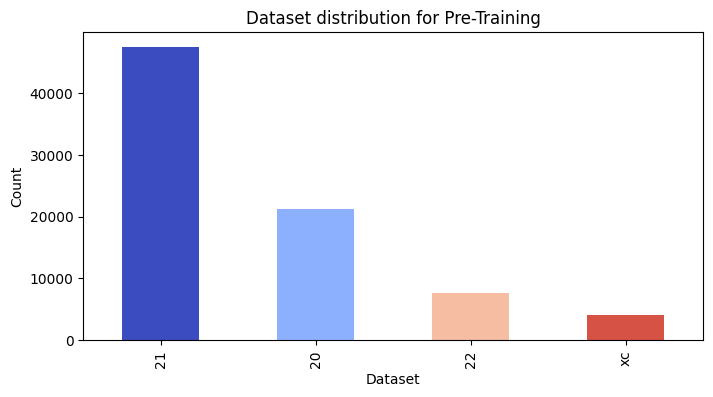

In [12]:
# BirdCLEF-2020
df_20 = pd.read_csv(f'{BASE_PATH0}/train.csv')
df_20['primary_label'] = df_20['ebird_code']
df_20['filepath'] = GCS_PATH0 + '/train_audio/' + df_20.primary_label + '/' + df_20.filename
df_20['scientific_name'] = df_20['sci_name']
df_20['common_name'] = df_20['species']
df_20['target'] = df_20.primary_label.map(CFG.name2label2)
df_20['birdclef'] = '20'
assert tf.io.gfile.exists(df_20.filepath.iloc[0])

# Xeno-Canto Extend by @vopani
df_xam = pd.read_csv(f'{BASE_PATH4}/train_extended.csv')
df_xam['filepath'] = GCS_PATH4 + '/A-M/' + df_xam.ebird_code + '/' + df_xam.filename
df_xnz = pd.read_csv(f'{BASE_PATH5}/train_extended.csv')
df_xnz['filepath'] = GCS_PATH5 + '/N-Z/' + df_xnz.ebird_code + '/' + df_xnz.filename
df_xc = pd.concat([df_xam, df_xnz], axis=0, ignore_index=True)
df_xc['primary_label'] = df_xc['ebird_code']
df_xc['scientific_name'] = df_xc['sci_name']
df_xc['common_name'] = df_xc['species']
df_xc['target'] = df_xc.primary_label.map(CFG.name2label2)
df_xc['birdclef'] = 'xc'
assert tf.io.gfile.exists(df_xc.filepath.iloc[0])

# BirdCLEF-2021
df_21 = pd.read_csv(f'{BASE_PATH1}/train_metadata.csv')
df_21['filepath'] = GCS_PATH1 + '/train_short_audio/' + df_21.primary_label + '/' + df_21.filename
df_21['target'] = df_21.primary_label.map(CFG.name2label2)
df_21['birdclef'] = '21'
corrupt_paths = ['/kaggle/input/birdclef-2021/train_short_audio/houwre/XC590621.ogg',
                 '/kaggle/input/birdclef-2021/train_short_audio/cogdov/XC579430.ogg']
df_21 = df_21[~df_21.filepath.isin(corrupt_paths)] # remove all zero audios
assert tf.io.gfile.exists(df_21.filepath.iloc[0])

# BirdCLEF-2022
df_22 = pd.read_csv(f'{BASE_PATH2}/train_metadata.csv')
df_22['filepath'] = GCS_PATH2 + '/train_audio/' + df_22.filename
df_22['target'] = df_22.primary_label.map(CFG.name2label2)
df_22['birdclef'] = '22'
assert tf.io.gfile.exists(df_22.filepath.iloc[0])

# Merge 2021 and 2022 for pretraining
df_pre = pd.concat([df_20, df_21, df_22, df_xc], axis=0, ignore_index=True)
df_pre['filename'] = df_pre.filepath.map(lambda x: x.split('/')[-1])
df_pre['xc_id'] = df_pre.filepath.map(lambda x: x.split('/')[-1].split('.')[0])
nodup_idx = df_pre[['xc_id','primary_label','author']].drop_duplicates().index
df_pre = df_pre.loc[nodup_idx].reset_index(drop=True)

# # Remove duplicates
df_pre = df_pre[~df_pre.xc_id.isin(df_23.xc_id)].reset_index(drop=True)
corrupt_mp3s = json.load(open('/kaggle/input/birdclef-corrupt-mp3-files-ds/corrupt_mp3_files.json','r'))
df_pre = df_pre[~df_pre.filepath.isin(corrupt_mp3s)]
df_pre = df_pre[['filename','filepath','primary_label','secondary_labels',
                 'rating','author','file_type','xc_id','scientific_name',
                'common_name','target','birdclef','bird_seen']]
# Display rows
print("# Samples for Pre-Training: {:,}".format(len(df_pre)))
df_pre.head(2).style.set_caption("Pre-Training Data").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'blue'),
        ('font-size', '16px')
    ]
}])

# Show distribution
plt.figure(figsize=(8, 4))
df_pre.birdclef.value_counts().plot.bar(color=[cmap(0.0),cmap(0.25), cmap(0.65), cmap(0.9)])
plt.xlabel("Dataset")
plt.ylabel("Count")
plt.title("Dataset distribution for Pre-Training")
plt.show()

# EDA 🎨

## Utility

In [13]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, 
                                   sr=CFG.sample_rate, 
                                   n_mels=CFG.img_size[0],
                                   n_fft=CFG.nfft,
                                   hop_length=CFG.hop_length,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    return spec

def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
#     print("# Image:")
#     show_image(row.common_name)
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                color= cmap(0.1))
    # Specplot
    lid.specshow(spec, 
                 sr = CFG.sample_rate, 
                 hop_length = CFG.hop_length,
                 n_fft=CFG.nfft,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

## BirdCLEF - 20

# BirdCLEF - 2020


# Audio:


# Visualization:


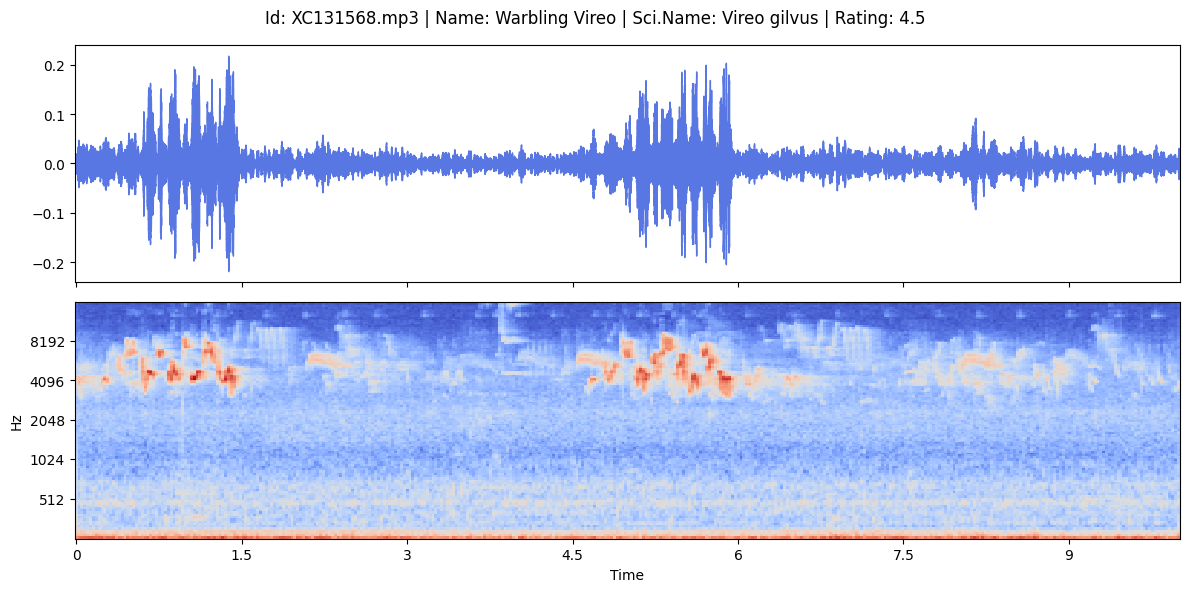

In [14]:
BIRDCLEF = '20'
print(f"# BirdCLEF - 20{BIRDCLEF}")
tmp = df_pre.query("birdclef==@BIRDCLEF").sample(1)
tmp.loc[:, 'filepath'] = tmp.filepath.str.replace(GCS_PATH0, BASE_PATH0)
row = tmp.squeeze()
# Display audio
display_audio(row)

## Xeno-Canto Extend

# Xeno-Canto - Extend
# Audio:


# Visualization:


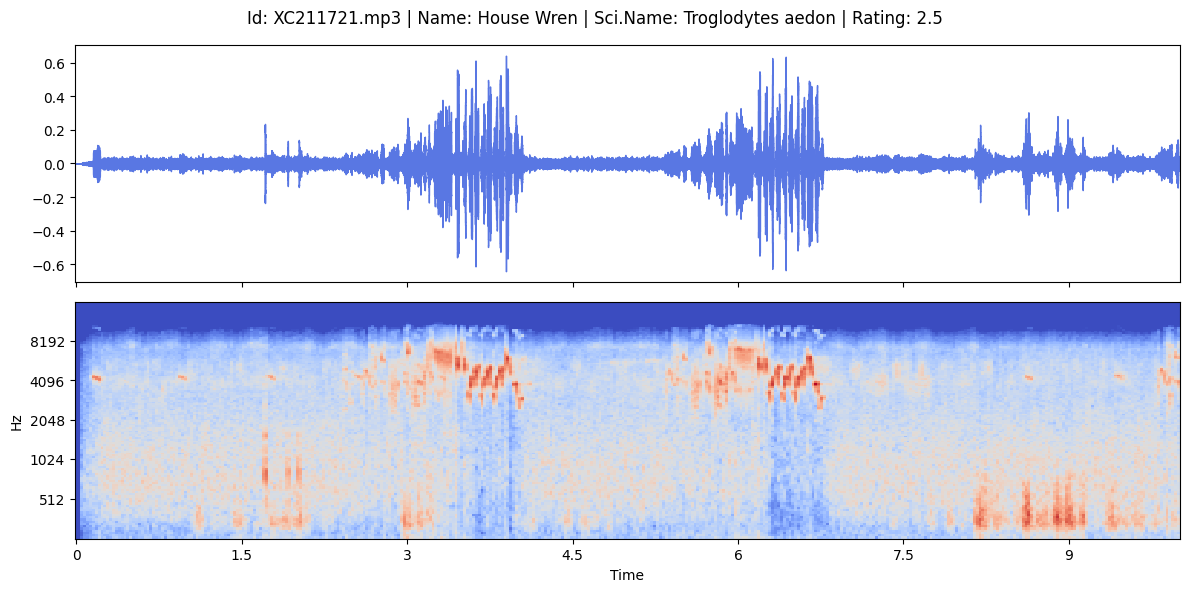

In [15]:
BIRDCLEF = 'xc'
print(f"# Xeno-Canto - Extend")
tmp = df_pre.query("birdclef==@BIRDCLEF").sample(1)
tmp.loc[:, 'filepath'] = tmp.filepath.str.replace(GCS_PATH4, BASE_PATH4).replace(GCS_PATH5, BASE_PATH5)
row = tmp.squeeze()
# Display audio
display_audio(row)

## BirdCLEF - 21

# BirdCLEF - 2021
# Audio:


# Visualization:


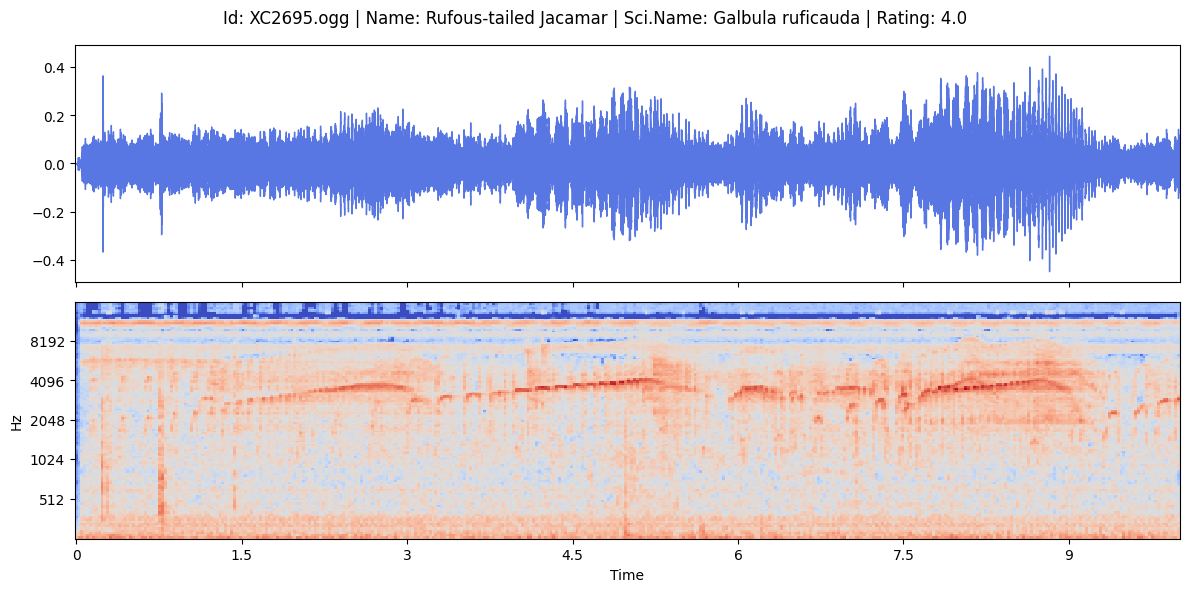

In [16]:
BIRDCLEF = '21'
print(f"# BirdCLEF - 20{BIRDCLEF}")
tmp = df_pre.query("birdclef==@BIRDCLEF").sample(1)
tmp.loc[:, 'filepath'] = tmp.filepath.str.replace(GCS_PATH1, BASE_PATH1)
row = tmp.squeeze()
# Display audio
display_audio(row)

## BirdCLEF - 22

# BirdCLEF - 2022
# Audio:


# Visualization:


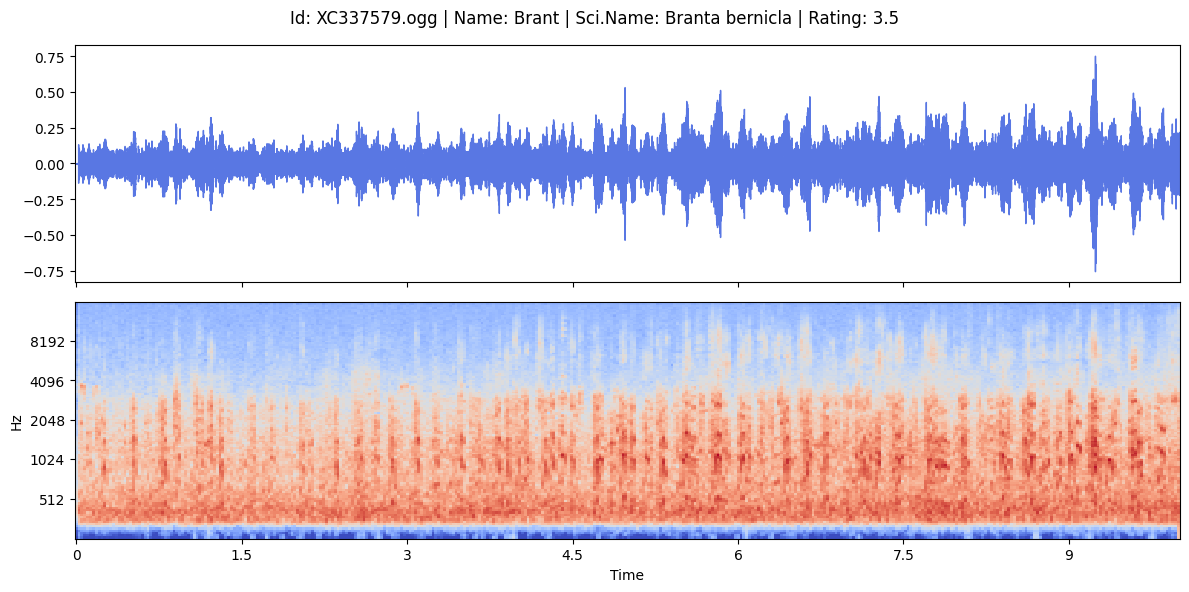

In [17]:
BIRDCLEF = '22'
print(f"# BirdCLEF - 20{BIRDCLEF}")
tmp = df_pre.query("birdclef==@BIRDCLEF").sample(1)
tmp.loc[:, 'filepath'] = tmp.filepath.str.replace(GCS_PATH2, BASE_PATH2)
row = tmp.squeeze()
# Display audio
display_audio(row)

## BirdCLEF - 23

# BirdCLEF - 2023
# Audio:


# Visualization:


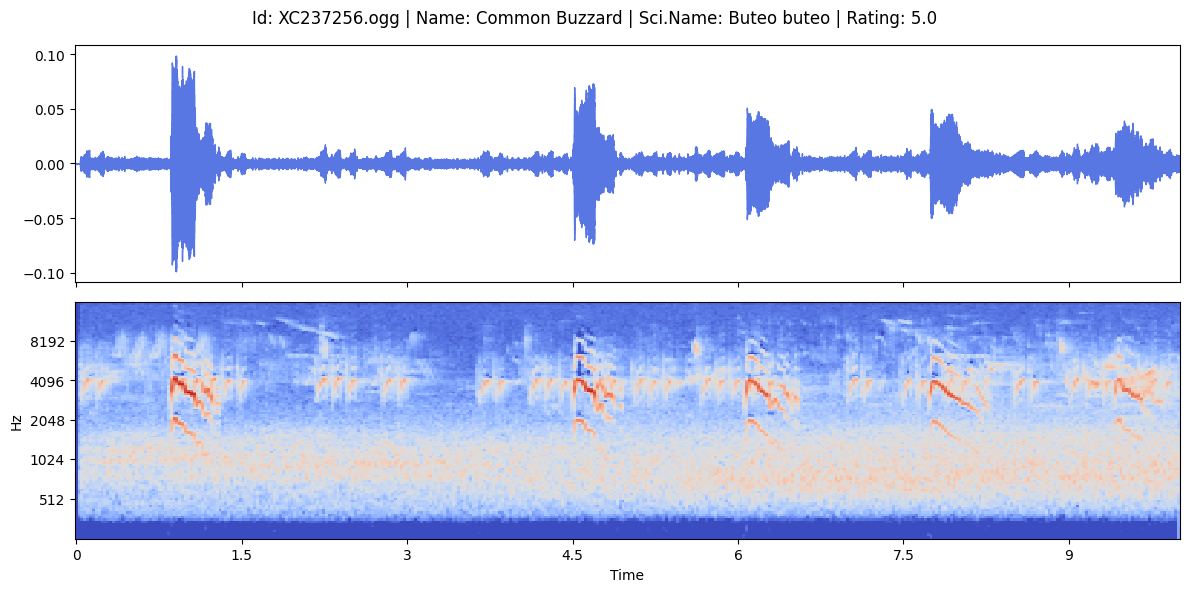

In [18]:
BIRDCLEF = '23'
print(f"# BirdCLEF - 20{BIRDCLEF}")
tmp = df_23.query("birdclef==@BIRDCLEF").sample(1)
tmp.loc[:, 'filepath'] = tmp.filepath.str.replace(GCS_PATH3, BASE_PATH3)
row = tmp.squeeze()

# Display audio
display_audio(row)

# Data Split 🔪
Following code will split the data into folds using target stratification.
> **Note:** Some classess have too few samples thus not each fold contains all the classes. 

In [19]:
# Import required packages
from sklearn.model_selection import StratifiedKFold

# Initialize the StratifiedKFold object with 5 splits and shuffle the data
skf1 = StratifiedKFold(n_splits=25, shuffle=True, random_state=CFG.seed)
skf2 = StratifiedKFold(n_splits=CFG.num_fold, shuffle=True, random_state=CFG.seed)

# Reset the index of the dataframe
df_pre = df_pre.reset_index(drop=True)
df_23 = df_23.reset_index(drop=True)

# Create a new column in the dataframe to store the fold number for each row
df_pre["fold"] = -1
df_23["fold"] = -1

# BirdCLEF - 21 & 22
for fold, (train_idx, val_idx) in enumerate(skf1.split(df_pre, df_pre['primary_label'])):
    df_pre.loc[val_idx, 'fold'] = fold
    
# IBirdCLEF - 23
for fold, (train_idx, val_idx) in enumerate(skf2.split(df_23, df_23['primary_label'])):
    df_23.loc[val_idx, 'fold'] = fold

/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=25.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


# Filter & Upsample Data ⬆️

* **Filter**: As there is even only one sample for some classes we need to make sure they are in the train data using filtering. We can do this by always keeping them in the train data and do cross-validtion on the rest of the data.

* **Upsample**: Even in the filtered data there are some minority classes with very few samples. To amend the class imbalance we can try upsampling those classes. Following function will simply upsample the train data for minory class which has very few samples. This can potentially mitigate the classic "Long Tail" problem.

* **Downsample**: Ensure maximum sample of a class.


In [20]:
def filter_data(df, thr=5):
    # Count the number of samples for each class
    counts = df.primary_label.value_counts()

    # Condition that selects classes with less than `thr` samples
    cond = df.primary_label.isin(counts[counts<thr].index.tolist())

    # Add a new column to select samples for cross validation
    df['cv'] = True

    # Set cv = False for those class where there is samples less than thr
    df.loc[cond, 'cv'] = False

    # Return the filtered dataframe
    return df
    
def upsample_data(df, thr=20):
    # get the class distribution
    class_dist = df['primary_label'].value_counts()

    # identify the classes that have less than the threshold number of samples
    down_classes = class_dist[class_dist < thr].index.tolist()

    # create an empty list to store the upsampled dataframes
    up_dfs = []

    # loop through the undersampled classes and upsample them
    for c in down_classes:
        # get the dataframe for the current class
        class_df = df.query("primary_label==@c")
        # find number of samples to add
        num_up = thr - class_df.shape[0]
        # upsample the dataframe
        class_df = class_df.sample(n=num_up, replace=True, random_state=CFG.seed)
        # append the upsampled dataframe to the list
        up_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    up_df = pd.concat([df] + up_dfs, axis=0, ignore_index=True)
    
    return up_df

def downsample_data(df, thr=500):
    # get the class distribution
    class_dist = df['primary_label'].value_counts()
    
    # identify the classes that have less than the threshold number of samples
    up_classes = class_dist[class_dist > thr].index.tolist()

    # create an empty list to store the upsampled dataframes
    down_dfs = []

    # loop through the undersampled classes and upsample them
    for c in up_classes:
        # get the dataframe for the current class
        class_df = df.query("primary_label==@c")
        # Remove that class data
        df = df.query("primary_label!=@c")
        # upsample the dataframe
        class_df = class_df.sample(n=thr, replace=False, random_state=CFG.seed)
        # append the upsampled dataframe to the list
        down_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    down_df = pd.concat([df] + down_dfs, axis=0, ignore_index=True)
    
    return down_df

## Filter Data

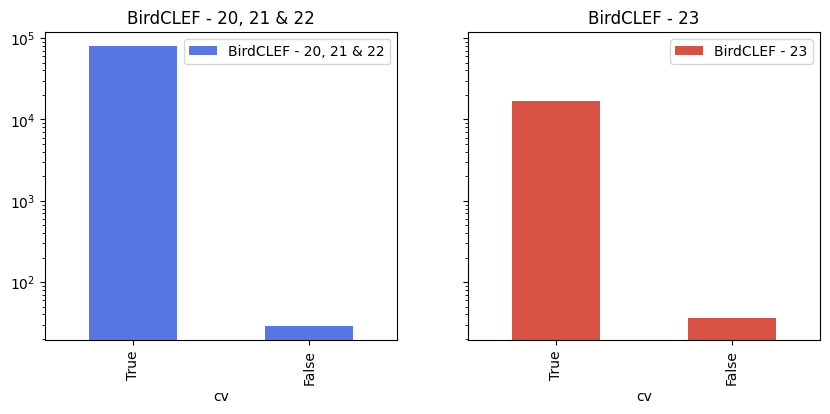

In [21]:
# Filter data
f_df = filter_data(df_pre, thr=5)

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
f_df.cv.value_counts().plot.bar(legend=True, color=cmap(0.1))
plt.yscale("log")
plt.title("BirdCLEF - 20, 21 & 22")
plt.legend(["BirdCLEF - 20, 21 & 22"])

f_df = filter_data(df_23, thr=5)
ax2 = plt.subplot(1, 2, 2, sharey = ax1)
f_df.cv.value_counts().plot.bar(legend=True, color=cmap(0.9))
plt.yscale("log")
plt.title("BirdCLEF - 23")
plt.legend(["BirdCLEF - 23"])

plt.show()

## Upsample Data

# Pretraing Dataset
> Original: 80394
> After Upsample: 88502
> After Downsample: 75805



# BirdCLEF - 23
> Before Upsample: 16941
> After Upsample: 22208


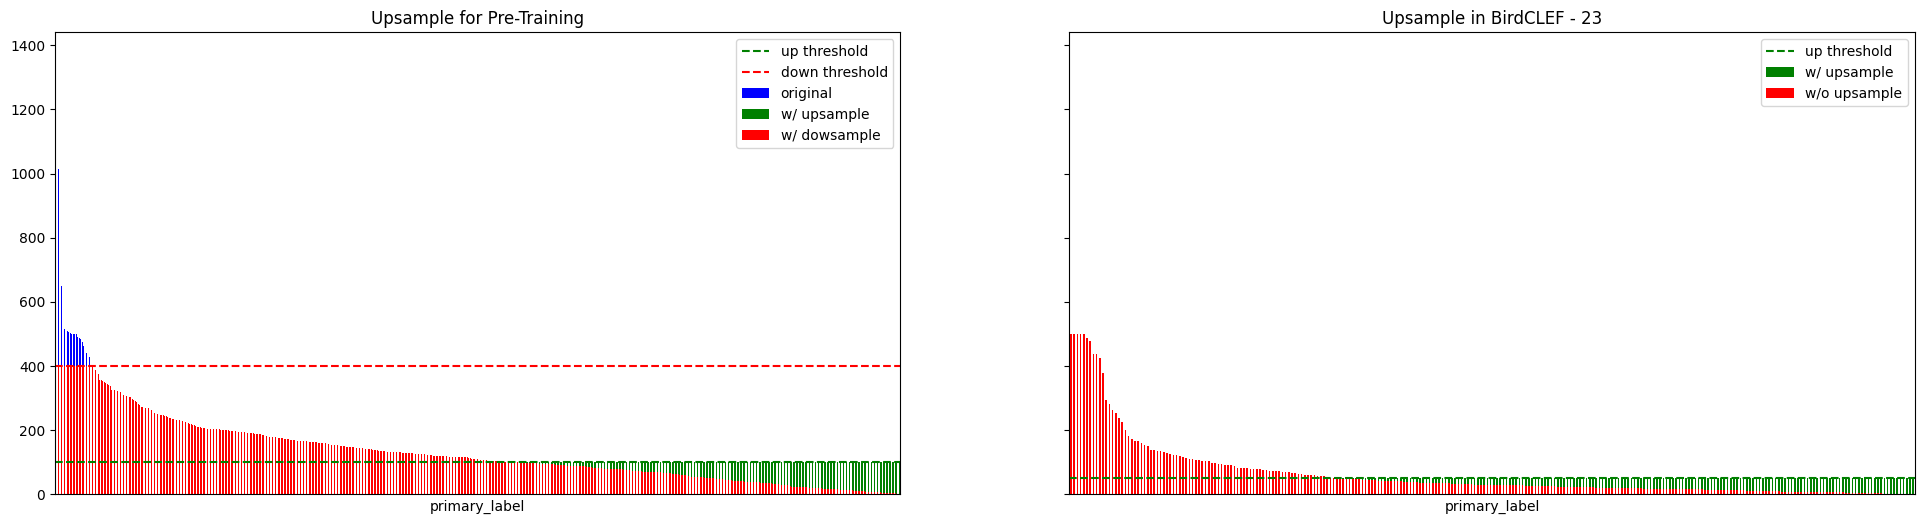

In [22]:
# Upsample data
up_thr = 100
dn_df = downsample_data(df_pre, thr=400)
up_df = upsample_data(dn_df, thr=up_thr)
print("# Pretraing Dataset")
print(f'> Original: {len(df_pre)}')
print(f'> After Upsample: {len(up_df)}')
print(f'> After Downsample: {len(dn_df)}')

# Show effect of upsample
plt.figure(figsize=(12*2, 6))

ax1 = plt.subplot(1, 2, 1)
df_pre.primary_label.value_counts()[:].plot.bar(color='blue', label='original')
up_df.primary_label.value_counts()[:].plot.bar(color='green', label='w/ upsample')
dn_df.primary_label.value_counts()[:].plot.bar(color='red', label='w/ dowsample')
plt.xticks([])
plt.axhline(y=up_thr, color='g', linestyle='--', label='up threshold')
plt.axhline(y=400, color='r', linestyle='--', label='down threshold')
plt.legend()
plt.title("Upsample for Pre-Training")
# plt.show()

# Upsample data
up_thr = 50
up_df = upsample_data(df_23, thr=up_thr)
print("\n# BirdCLEF - 23")
print(f'> Before Upsample: {len(df_23)}')
print(f'> After Upsample: {len(up_df)}')

# Show effect of upsample
ax2 = plt.subplot(1, 2, 2, sharey=ax1)
up_df.primary_label.value_counts()[:].plot.bar(color='green', label='w/ upsample')
df_23.primary_label.value_counts()[:].plot.bar(color='red', label='w/o upsample')
plt.xticks([])
plt.axhline(y=up_thr, color='g', linestyle='--', label='up threshold')
plt.legend()
plt.title("Upsample in BirdCLEF - 23")

# plt.tight_layout()
plt.show()

# Data Augmentation 🌈
> **Caution:** Even though we are training audio as an image (spectrogram), we can't use typical computer-vision augmentations such as HorizontalFlip, Rotation, Shear, etc as it may contaminate the information contained within the image (spectrogram). For example, if we rotate a spectrogram then it doesn't make sense anymore as we can't relate this rotated spectrogram to the actual audio. 

## Used Augmentations
Two types of Augmentations are used here, 
1. **AudioAug**: Augmentations that will be applied directly to **audio** data. Example: Gaussian Noise, Random CropPad, CutMix and MixUp
2. **SpecAug**: Augmentations that will be applied to **spectrogram** data. Example: TimeFreqMask.

## Utility

In [23]:
# Generates random integer
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)


# Generats random float
def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

## AudioAug
Applies augmentation directly to audio

In [24]:
# Import required packages
import tensorflow_extra as tfe

# Randomly shift audio -> any sound at <t> time may get shifted to <t+shift> time
@tf.function
def TimeShift(audio, prob=0.5):
    # Randomly apply time shift with probability `prob`
    if random_float() < prob:
        # Calculate random shift value
        shift = random_int(shape=[], minval=0, maxval=tf.shape(audio)[0])
        # Randomly set the shift to be negative with 50% probability
        if random_float() < 0.5:
            shift = -shift
        # Roll the audio signal by the shift value
        audio = tf.roll(audio, shift, axis=0)
    return audio

# Apply random noise to audio data
@tf.function
def GaussianNoise(audio, std=[0.0025, 0.025], prob=0.5):
    # Select a random value of standard deviation for Gaussian noise within the given range
    std = random_float([], std[0], std[1])
    # Randomly apply Gaussian noise with probability `prob`
    if random_float() < prob:
        # Add random Gaussian noise to the audio signal
        GN = tf.keras.layers.GaussianNoise(stddev=std)
        audio = GN(audio, training=True) # training=False don't apply noise to data
    return audio

# Applies augmentation to Audio Signal
def AudioAug(audio):
    # Apply time shift and Gaussian noise to the audio signal
    audio = TimeShift(audio, prob=CFG.timeshift_prob)
    audio = GaussianNoise(audio, prob=CFG.gn_prob)
    return audio

# CutMix & MixUp
mixup_layer = tfe.layers.MixUp(alpha=CFG.mixup_alpha, prob=CFG.mixup_prob)
cutmix_layer = tfe.layers.CutMix(alpha=CFG.cutmix_alpha, prob=CFG.cutmix_prob)

def CutMixUp(audios, labels):
    audios, labels = mixup_layer(audios, labels, training=True)
    audios, labels = cutmix_layer(audios, labels, training=True)
    return audios, labels

# Data Loader 🍚

## Decoders
Following code will decode the raw audio from `.ogg` file and also decode spectrogram from `audio` file.

In [25]:
# Decodes Audio
def audio_decoder(with_labels=True, dim=CFG.audio_len, 
                  take_first=False, num_classes=264, CFG=CFG):
    def get_audio(filepath):
        ftype = filepath[1]
        filepath = filepath[0]
        file_bytes = tf.io.read_file(filepath)
        if ftype:
            audio = tfio.audio.decode_vorbis(file_bytes) # decode .ogg file
        else:
            audio = tfio.audio.decode_mp3(file_bytes) # decode .mp3 file
        audio = tf.cast(audio, tf.float32)
        if tf.shape(audio)[1]>1: # stereo -> mono
            audio = audio[...,0:1]
        audio = tf.squeeze(audio, axis=-1)
        return audio
    
    def crop_or_pad(audio, target_len, pad_mode='constant', take_first=True):
        audio_len = tf.shape(audio)[0]
        diff_len = abs(target_len - audio_len)
        if audio_len < target_len:
            pad1 = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            pad2 = diff_len - pad1
            audio = tf.pad(audio, paddings=[[pad1, pad2]], mode=pad_mode)
        elif audio_len > target_len:
            if take_first:
                audio = audio[:target_len]
            else:
                idx = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
                audio = audio[idx: (idx + target_len)]
        return tf.reshape(audio, [target_len])

    def get_target(target):          
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, num_classes), tf.float32) 
        target = tf.reshape(target, [num_classes])
        return target

    def decode(path):
        audio = get_audio(path)
        audio = crop_or_pad(audio, dim) # crop or pad audio to keep a fixed length
        audio = tf.reshape(audio, [dim])
        return audio
    
    def decode_with_labels(path, label):
        label = get_target(label)
        return decode(path), label
    
    return decode_with_labels if with_labels else decode

## Augmenters
Following code will apply augmentations to audio and spectrogram.

In [26]:
# Applies augmentation to audio
def audio_augmenter(with_labels=True, dim=CFG.audio_len, CFG=CFG):
    def augment(audio, dim=dim):
        if random_float() <= CFG.audio_augment_prob:
            audio = AudioAug(audio)
        audio = tf.reshape(audio, [dim])
        return audio
    
    def augment_with_labels(audio, label):    
        return augment(audio), label
    
    return augment_with_labels if with_labels else augment

## Data Pipeline
Following code builds the complete pipeline of the data flow. It uses `tf.data.Dataset` for data processing. Here are some cool features of `tf.data`,
* We can build complex input pipelines from simple, reusable pieces using`tf.data` API . For example, the pipeline for an audio model might aggregate data from files in a distributed file system, apply random transformation/augmentation to each audio, and merge randomly selected audios into a batch for training.
* Moreover `tf.data` API provides a `tf.data.Dataset` feature that represents a sequence of components where each component comprises one or more pieces. For instance, in an audio pipeline, a component might be a single training example, with a pair of tensor pieces representing the audio and its label.

Check out this [doc](https://www.tensorflow.org/guide/data) if you want to learn more about `tf.data`.

In [27]:
def build_dataset(paths, ftype, labels=None, batch_size=32, target_size=[128, 256], 
                  audio_decode_fn=None, audio_augment_fn=None,
                  take_first=False, num_classes=264,
                  cache=True, cache_dir="",drop_remainder=False,
                  augment=True, repeat=True, shuffle=1024):
    """
    Creates a TensorFlow dataset from the given paths and labels.
    
    Args:
        paths (list): A list of file paths to the audio files.
        labels (list): A list of corresponding labels for the audio files.
        batch_size (int): Batch size for the created dataset.
        target_size (list): A list of target image size for the spectrograms.
        audio_decode_fn (function): A function to decode the audio file.
        audio_augment_fn (function): A function to augment the audio file.
        cache (bool): Whether to cache the dataset or not.
        cache_dir (str): Directory path to cache the dataset.
        drop_remainder (bool): Whether to drop the last batch if it is smaller than batch_size.
        augment (bool): Whether to augment the dataset or not.
        repeat (bool): Whether to repeat the dataset or not.
        shuffle (int): Number of elements from the dataset to buffer for shuffling.
        
    Returns:
        ds (tf.data.Dataset): A TensorFlow dataset.
    """
    # Create cache directory if cache is enabled
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    # Set default audio decode function if not provided
    if audio_decode_fn is None:
        audio_decode_fn = audio_decoder(labels is not None,
                                        dim=CFG.audio_len, 
                                        take_first=take_first,
                                        num_classes=num_classes,
                                        CFG=CFG)
    # Set default audio augmentation function if not provided
    if audio_augment_fn is None:
        audio_augment_fn = audio_augmenter(labels is not None, 
                                           dim=CFG.audio_len, CFG=CFG)
        
    # Set TensorFlow AUTOTUNE option
    AUTO = tf.data.experimental.AUTOTUNE
    # Create slices based on whether labels are provided
    slices = ((paths, ftype),) if labels is None else ((paths, ftype), labels)
    # Create TensorFlow dataset from slices
    ds = tf.data.Dataset.from_tensor_slices(slices)
    # Map audio decode function to dataset
    ds = ds.map(audio_decode_fn, num_parallel_calls=AUTO)
    # Cache dataset in memory if cache is enabled
    ds = ds.cache(cache_dir) if cache else ds
    # Repeat dataset indefinitely if repeat is enabled
    ds = ds.repeat() if repeat else ds
    # Create TensorFlow dataset options
    opt = tf.data.Options()
    # Shuffle dataset if shuffle is enabled
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
    if CFG.device=='GPU':
        # If the device is a GPU, turn off auto-sharding to avoid performance issues
        opt.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
    # Set the options for the dataset
    ds = ds.with_options(opt)
    # Apply audio augmentation to the dataset if augment is True
    ds = ds.map(audio_augment_fn, num_parallel_calls=AUTO) if augment else ds
    # Batch the dataset with the specified batch size
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    # Apply MixUp & CutMix regularization to the dataset
    if augment and labels is not None:
        ds = ds.map(CutMixUp,num_parallel_calls=AUTO)
    # Prefetch the next batch of data to improve performance
    ds = ds.prefetch(AUTO)
    return ds

# Visualization 🔭
To ensure our pipeline is generating **spectrogram** and its associate **label** correctly, we'll check some samples from a batch.

In [28]:
def plot_batch(batch, row=3, col=3, label2name=None,):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        audios, tars = batch
    else:
        audios = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        plt.plot(audios[idx].numpy(), color=cmap(0.1))
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()
    
    
def plot_history(history):
    """Plot trainign history, credit: @cdeotte"""
    epochs = len(history.history['auc'])
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(epochs),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
    plt.plot(np.arange(epochs),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
    x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
    plt.ylabel('AUC (PR)',size=14); plt.xlabel('Epoch',size=14)
    plt.legend(loc=2)
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(epochs),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(epochs),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.title('Fold %i - Training Plot'%(fold+1),size=18)
    plt.legend(loc=3)
    plt.show()  

## BirdCLEF - 20

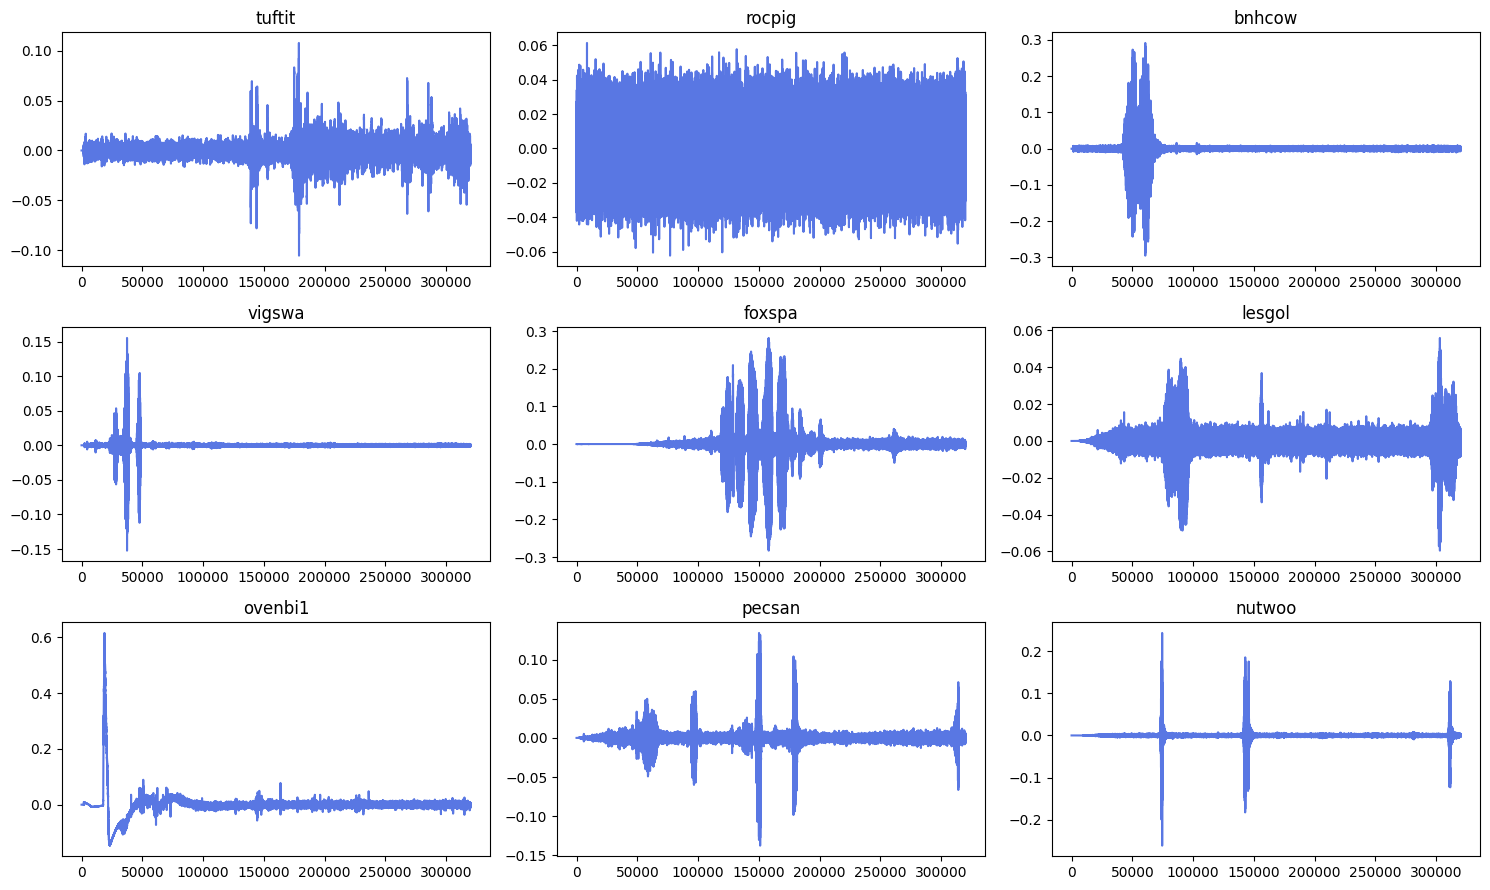

In [29]:
check_df = df_pre.query("birdclef=='20'").sample(50)
ds = build_dataset(check_df.filepath.tolist(),
                   check_df.filepath.str.contains('.ogg').tolist(),
                   check_df.target.tolist(), 
                   num_classes=CFG.num_classes2,
                   augment=True, cache=False)
ds = ds.take(32)
audios, labels = next(iter(ds))
plot_batch((audios, labels), label2name=CFG.label2name2)

## Xeno-Canto Extend

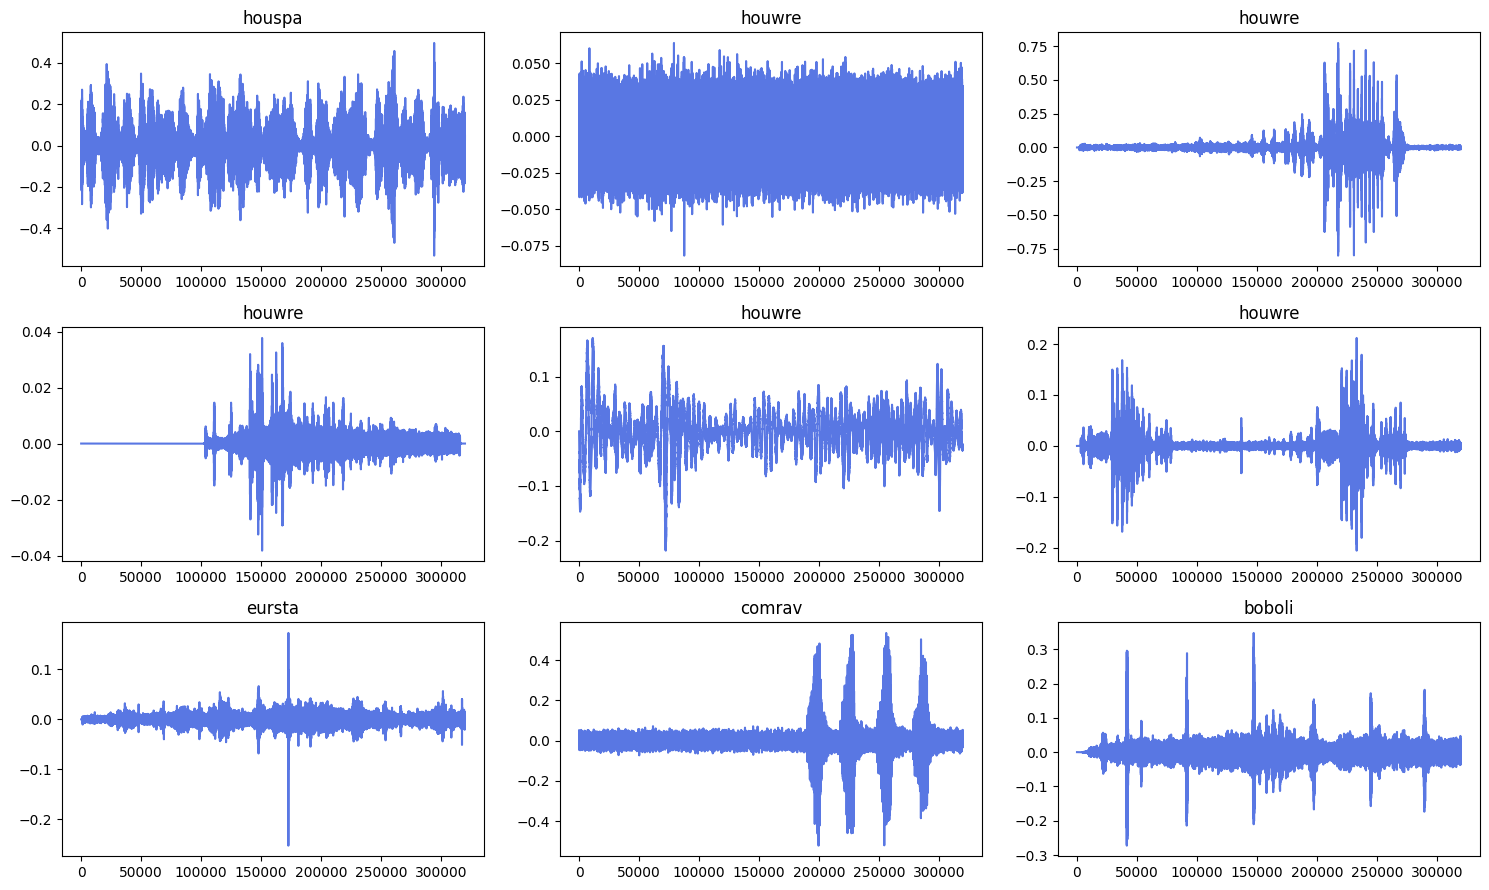

In [30]:
check_df = df_pre.query("birdclef=='xc'").sample(50)
ds = build_dataset(check_df.filepath.tolist(),
                   check_df.filepath.str.contains('.ogg').tolist(),
                   check_df.target.tolist(), 
                   num_classes=CFG.num_classes2,
                   augment=True, cache=False)
ds = ds.take(32)
audios, labels = next(iter(ds))
plot_batch((audios, labels), label2name=CFG.label2name2)

## BirdCLEF - 21

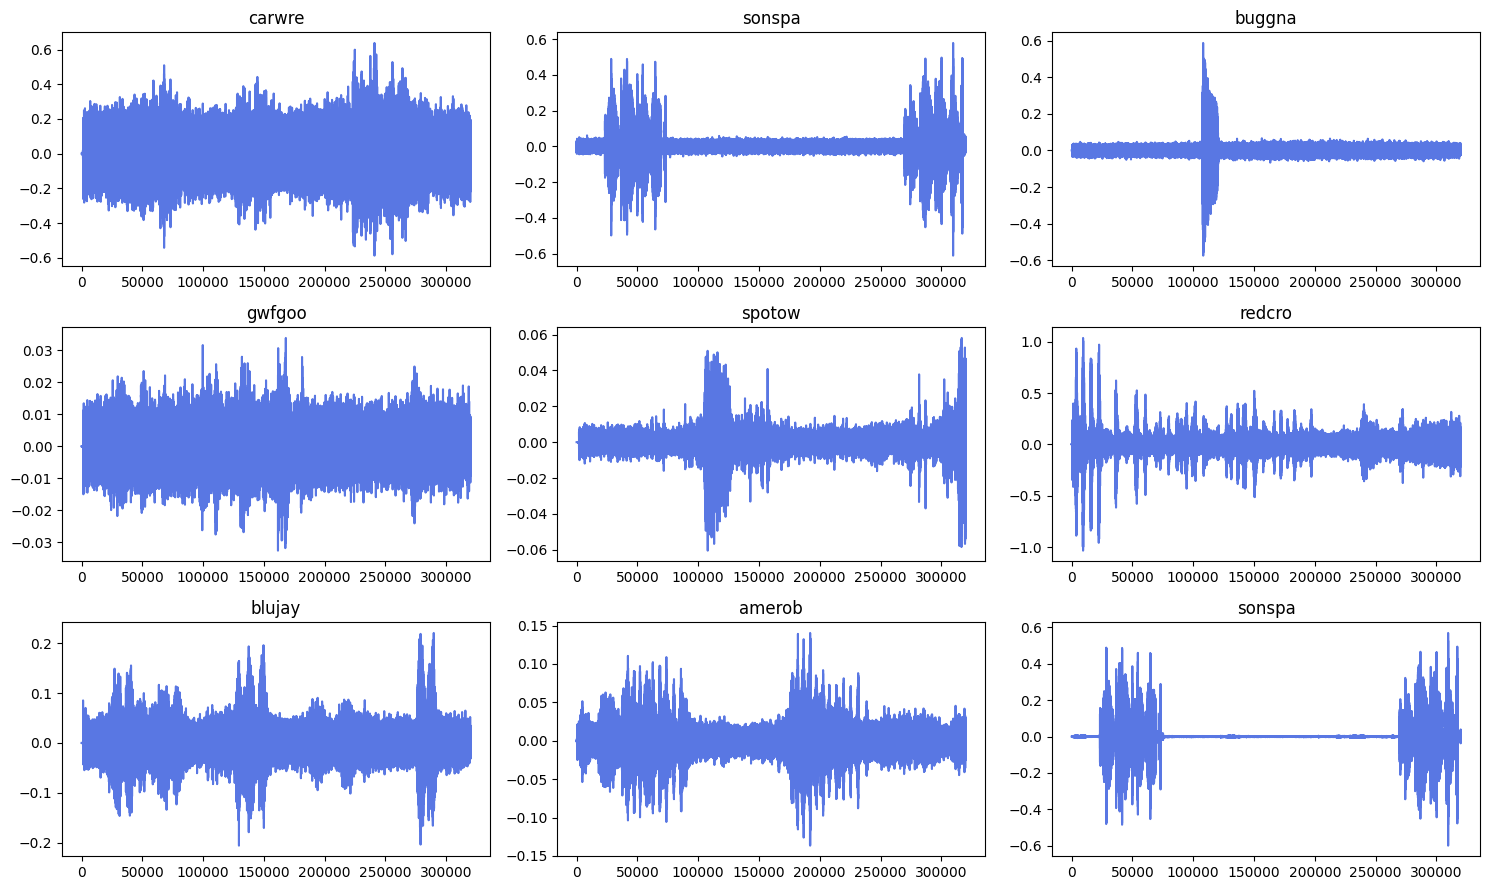

In [31]:
check_df = df_pre.query("birdclef=='21'").sample(50)
ds = build_dataset(check_df.filepath.tolist(),
                   check_df.filepath.str.contains('.ogg').tolist(),
                   check_df.target.tolist(), 
                   num_classes=CFG.num_classes2,
                   augment=True, cache=False)
ds = ds.take(32)
audios, labels = next(iter(ds))
plot_batch((audios, labels), label2name=CFG.label2name2)

## BirdCLEF - 22

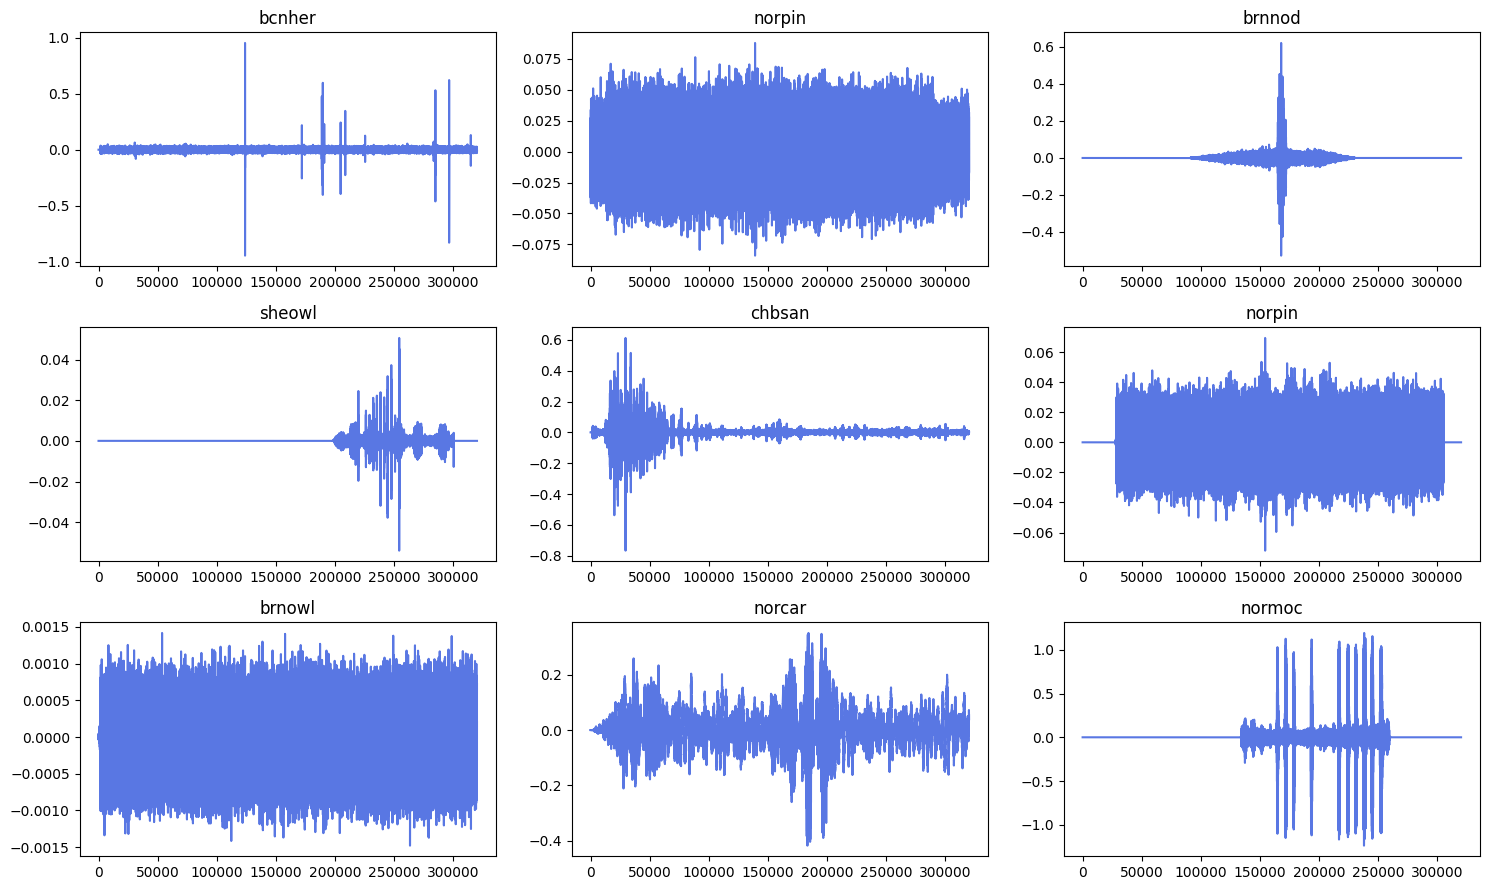

In [32]:
check_df = df_pre.query("birdclef=='22'").sample(50)
ds = build_dataset(check_df.filepath.tolist(),
                   check_df.filepath.str.contains('.ogg').tolist(),
                   check_df.target.tolist(), 
                   num_classes=CFG.num_classes2,
                   augment=True, cache=False)
ds = ds.take(32)
audios, labels = next(iter(ds))
plot_batch((audios, labels), label2name=CFG.label2name2)

## BirdCLEF - 23

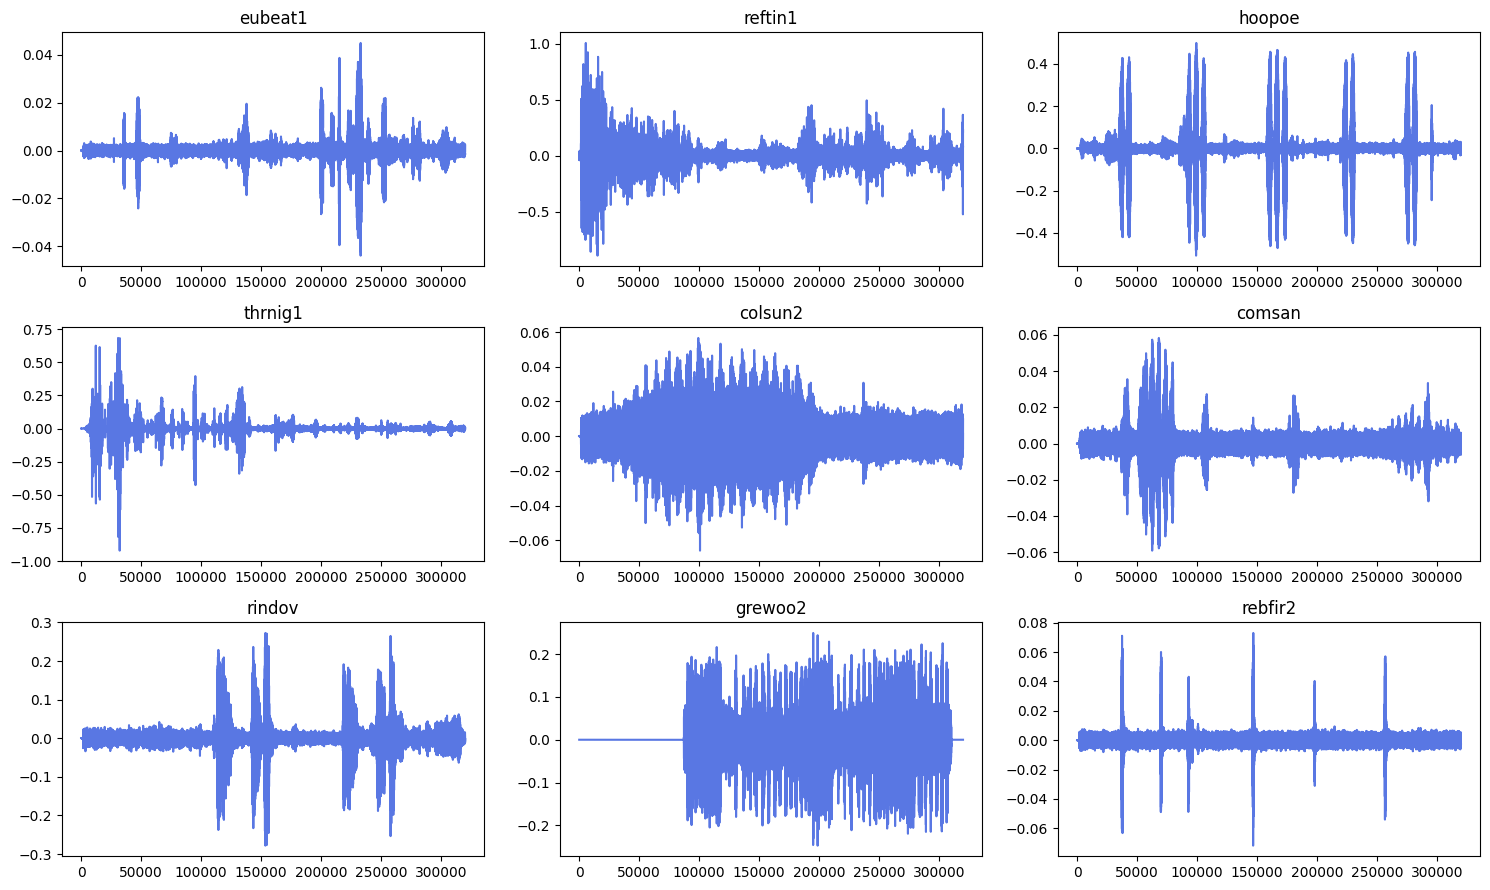

In [33]:
check_df = df_23.sample(50)
ds = build_dataset(check_df.filepath.tolist(),
                   check_df.filepath.str.contains('.ogg').tolist(),
                   check_df.target.tolist(), 
                   num_classes=CFG.num_classes2,
                   augment=True, cache=False)
ds = ds.take(32)
audios, labels = next(iter(ds))
plot_batch((audios, labels), label2name=CFG.label2name)

# Preprocessing Layers 🧂
This layers will preprocess audio data before feeding them to model. Specifically, `MelSpectrogram` layer will convert audio data to spectrogram, `TimeFreqMask` layer will apply time and freq masking to spectrogram, `ZScoreMinMax` layer will apply normalization and rescaling to spectrogram data.

> **Note**: This operations will be done in GPU/TPU thus will speed up the training alot and reduce CPU bottle created by `tf.data`

## MelSpectrogram
This layer converts audio data to spectrogram data on GPU/TPU. Thus can speed up significantly.

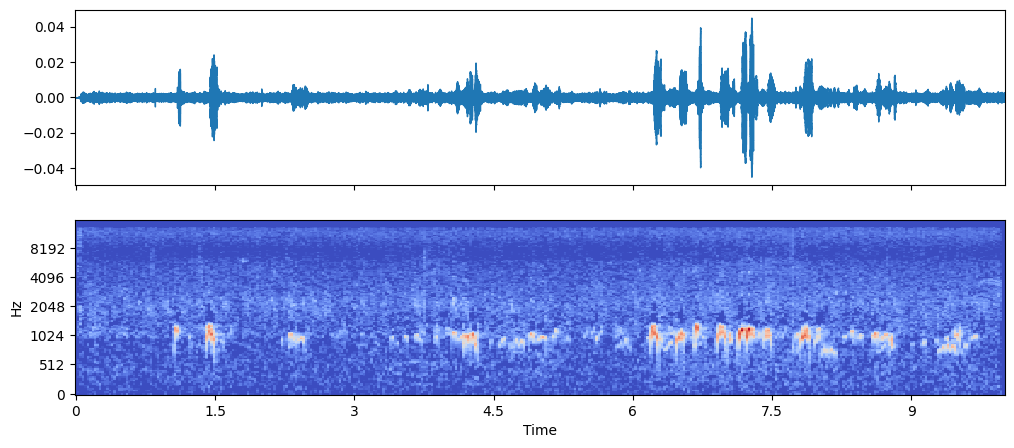

In [34]:
melspec_layer = tfe.layers.MelSpectrogram(n_fft=CFG.nfft, 
                                          hop_length=CFG.hop_length, 
                                          sr=CFG.sample_rate, 
                                          ref=1.0,
                                          fmin=500,
                                          fmax=15000,
                                          out_channels=3)
specs = melspec_layer(audios)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
lid.waveshow(audios[0].numpy(), sr=CFG.sample_rate, ax=ax[0], axis=None)

lid.specshow(specs[0, ..., 0].numpy(), 
             n_fft=CFG.nfft, 
             hop_length=CFG.hop_length, 
             sr=CFG.sample_rate,
             x_axis='time',
             y_axis='mel',
             cmap='coolwarm',
              ax=ax[1])
plt.show()

## SpecAug - Time Frequency Masking
This layer masks time frames and frequency ranges during training for augmentation.

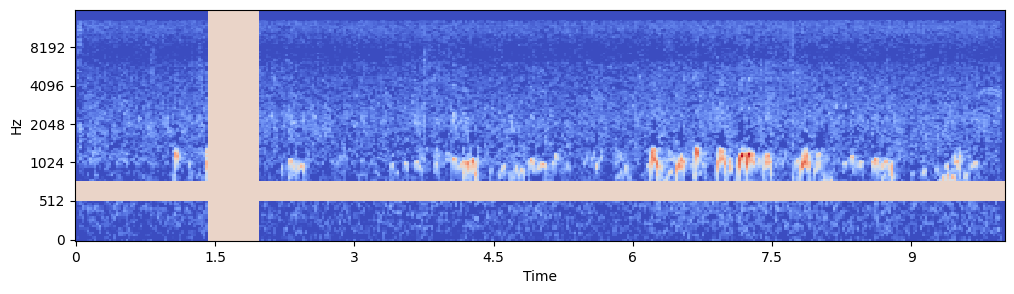

In [35]:
tfm_layer = tfe.layers.TimeFreqMask(freq_mask_prob=0.65,
                                  num_freq_masks=2,
                                  freq_mask_param=10,
                                  time_mask_prob=0.65,
                                  num_time_masks=3,
                                  time_mask_param=25,
                                  time_last=True,)
specs2 = tfm_layer(specs, training=True)

plt.figure(figsize=(12,3))
lid.specshow(specs2[0, ..., 0].numpy(), 
             n_fft=CFG.nfft, 
             hop_length=CFG.hop_length, 
             sr=CFG.sample_rate,
            x_axis='time',
            y_axis='mel',
            cmap='coolwarm')
plt.show()

## Normalization
This layer first Standardize the data using mean ans std then rescales the data to [0, 1]

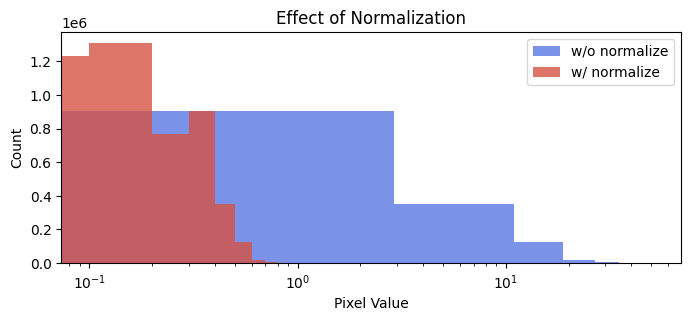

In [36]:
norm_layer = tfe.layers.ZScoreMinMax()
specs3 = norm_layer(specs2)

plt.figure(figsize=(8,3))
plt.hist(specs2.numpy().ravel(), alpha=0.8, color=cmap(0.1))
plt.hist(specs3.numpy().ravel(), alpha=0.8, color=cmap(0.9))
plt.legend(["w/o normalize", "w/ normalize"])
plt.semilogx()
plt.title("Effect of Normalization")
plt.xlabel("Pixel Value")
plt.ylabel("Count")
plt.show()

# Loss, Metric & Optmizer 📉
This notebook will use the `Categorical Cross Entropy (CCE)` loss for optimization, accompanied by `AUC (PR Curve)` and `Accuracy` as performance metrics. The model's efficacy will be evaluated using the padded `cmAP` metric, which is a variant of the `macro-averaged average precision` score that is implemented in scikit-learn. You can learn more about `cmAP` metric from [here](https://www.kaggle.com/competitions/birdclef-2023/overview/evaluation). Finally, it will use `Adam` optmizer for training the model.

$$
CCE = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{i,j} \log(p_{i,j})
$$

> **Note:** To account for cases where there are zero true positive labels for certain species, and to mitigate the impact of species with very few positive labels, this metric adds five rows of true positives to both the ground_truth and the prediction prior to scoring. This padding technique leads to even the baseline submission having a relatively strong score.

> **Note**: This notebook will use `Precision Recall (PR)` curve for AUC metric instead of typical `ROC` curve.

In [37]:
import sklearn.metrics

def get_metrics():
#     acc = tf.keras.metrics.BinaryAccuracy(name='acc')
    auc = tf.keras.metrics.AUC(curve='PR', name='auc', multi_label=False) # auc on prcision-recall curve
    acc = tf.keras.metrics.CategoricalAccuracy(name='acc')
    return [acc, auc]

def padded_cmap(y_true, y_pred, padding_factor=5):
    num_classes = y_true.shape[1]
    pad_rows = np.array([[1]*num_classes]*padding_factor)
    y_true = np.concatenate([y_true, pad_rows])
    y_pred = np.concatenate([y_pred, pad_rows])
    score = sklearn.metrics.average_precision_score(y_true, y_pred, average='macro',)
    return score

def get_loss():
    if CFG.loss=="CCE":
        loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=CFG.label_smoothing)
    elif CFG.loss=="BCE":
        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=CFG.label_smoothing)
    else:
        raise ValueError("Loss not found")
    return loss
    
def get_optimizer():
    if CFG.optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=CFG.lr)
    else:
        raise ValueError("Optmizer not found")
    return opt

# Modeling 🤖
* Similar to previous notebook, this notebook will also use `EFficientNet` models with `FSR` for pre-training and training.
* Additionally, in this notebook model will use pre-processing layers for processing raw audio on GPU/TPU to speed up the training.

In [38]:
import efficientnet.tfkeras as efn
import tensorflow_extra as tfe

# Will download and load pretrained imagenet weights.
def build_model(CFG, model_name=None, num_classes=264, compile_model=True):
    """
    Builds and returns a model based on the specified configuration.
    """
    # Create an input layer for the model
    inp = tf.keras.layers.Input(shape=(None,))
    # Spectrogram
    out = tfe.layers.MelSpectrogram(n_mels=CFG.img_size[0],
                                    n_fft=CFG.nfft,
                                    hop_length=CFG.hop_length, 
                                    sr=CFG.sample_rate,
                                    ref=1.0,
                                    out_channels=3)(inp)
    # Normalize
    out = tfe.layers.ZScoreMinMax()(out)
    # TimeFreqMask
    out = tfe.layers.TimeFreqMask(freq_mask_prob=0.5,
                                  num_freq_masks=1,
                                  freq_mask_param=10,
                                  time_mask_prob=0.5,
                                  num_time_masks=2,
                                  time_mask_param=25,
                                  time_last=False,)(out)
    # Load backbone model
    base = getattr(efn, model_name)(input_shape=(None, None, 3),
                                            include_top=0,
                                            weights=CFG.pretrain,
                                           fsr=CFG.fsr)
    # Pass the input through the base model
    out = base(out)
    out = tf.keras.layers.GlobalAveragePooling2D()(out)
    out = tf.keras.layers.Dense(num_classes, activation='softmax')(out)
    model = tf.keras.models.Model(inputs=inp, outputs=out)
    if compile_model:
        # Set the optimizer
        opt = get_optimizer()
        # Set the loss function
        loss = get_loss()
        # Set the evaluation metrics
        metrics = get_metrics()
        # Compile the model with the specified optimizer, loss function, and metrics
        model.compile(optimizer=opt, loss=loss, metrics=metrics)
    return model

In [39]:
model = build_model(CFG, model_name=CFG.model_name)
model.summary()

    8192/27164032 [..............................] - ETA: 0s

 1081344/27164032 [>.............................] - ETA: 1s

 4218880/27164032 [===>..........................] - ETA: 0s

 4251648/27164032 [===>..........................] - ETA: 1s

 8552448/27164032 [========>.....................] - ETA: 0s

20234240/27164032 [=====================>........] - ETA: 0s

27164032/27164032 [==============================] - 0s 0us/step


Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, None)]            0         


 mel_spectrogram (MelSpectro  (None, 128, None, 3)     0         


 gram)                                                           


 z_score_min_max (ZScoreMinM  (None, 128, None, 3)     0         


 ax)                                                             


 time_freq_mask (TimeFreqMas  (None, 128, None, 3)     0         


 k)                                                              


 efficientnet-b1 (Functional  (None, None, None, 1280)  6575232  


 )                                                               


 global_average_pooling2d (G  (None, 1280)             0         


 lobalAveragePooling2D)                                          


 dense (Dense)               (None, 264)               338184    


Total params: 6,913,416


Trainable params: 6,851,368


Non-trainable params: 62,048


_________________________________________________________________


## Check Model O/P

In [40]:
audios = tf.random.uniform((1, CFG.audio_len))
with strategy.scope():
    out = model(audios, training=False)
print(out.shape)

(1, 264)


# LR Schedule ⚓
* Learning Rate scheduler for transfer learning. 
* The learning rate starts from `lr_start`, then decreases to a`lr_min` using different methods namely,
    * **step**: Reduce lr step wise like stair.
    * **cos**: Follow Cosine graph to reduce lr.
    * **exp**: Reduce lr exponentially.

In [41]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=CFG.epochs, plot=False):
    """
    Returns a learning rate scheduler callback for a given batch size, mode, and number of epochs.
    """
    # Define the learning rate schedule.
    lr_start   = 0.000005
    lr_max     = 0.00000140 * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    # Function to update the lr
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max

        elif CFG.scheduler == 'exp':
            lr = (lr_max - lr_min) * lr_decay**(epoch - \
                  lr_ramp_ep - lr_sus_ep) + lr_min

        elif CFG.scheduler == 'step':
            lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)

        elif CFG.scheduler == 'cos':
            decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            cosine_decay = 0.5 * (1 + math.cos(phase))
            lr = (lr_max - lr_min) * cosine_decay + lr_min
        return lr
    
    # Plot the lr curve
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()
        
    # Crate lr-callback to update lr during training
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

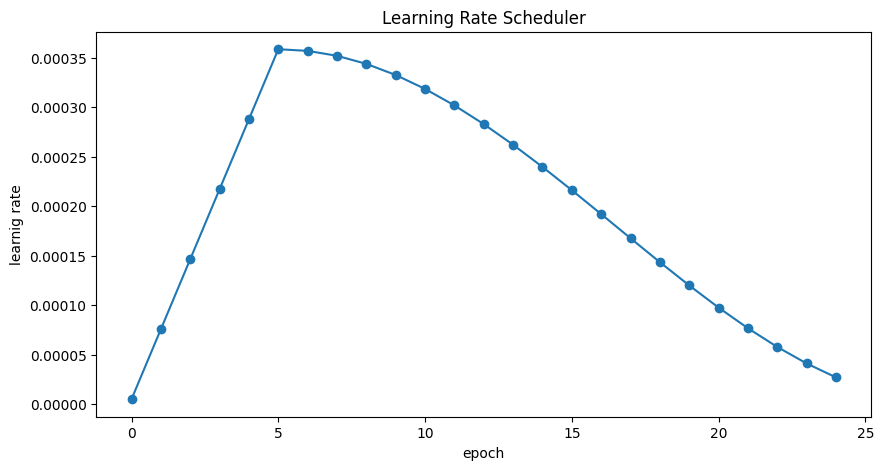

In [42]:
_=get_lr_callback(CFG.batch_size*CFG.replicas, plot=True)

# Wandb Logger 🕵️

The following code cell contains code to log data to WandB. It is noteworthy that the newly released callbacks offer more flexibility in terms of customization, and they are more compact compared to the classic `WandbCallback`, making it easier to use. Here's a brief introduction to them:

* **WandbModelCheckpoint**: This callback saves the model or weights using `tf.keras.callbacks.ModelCheckpoint`. Hence, we can harness the power of the official TensorFlow callback to log even `tf.keras.Model` subclass model in TPU.
* **WandbMetricsLogger**: This callback simply logs all the metrics and losses.
* **WandbEvalCallback**: This one is even more special. We can use it to log the model's prediction after a certain epoch/frequency. We can use it to save segmentation masks, bounding boxes, GradCAM within epochs to check intermediate results and so on.

For more details, please check the [official documentation](https://docs.wandb.ai/ref/python/integrations/keras).

In [43]:
import yaml

def wandb_init(fold):
    """
    Initializes the W&B run by creating a config file and initializing a W&B run.
    """
    # Create a dictionary of configuration parameters
    config = {k:v for k,v in dict(vars(CFG)).items() if '__' not in k}
    config.update({"fold":int(fold)}) # int is to convert numpy.int -> int
    # Dump the configuration dictionary to a YAML file
    yaml.dump(config, open(f'/kaggle/working/config fold-{fold}.yaml', 'w'),)
    # Load the configuration dictionary from the YAML file
    config = yaml.load(open(f'/kaggle/working/config fold-{fold}.yaml', 'r'), Loader=yaml.FullLoader)
    # Initialize a W&B run with the given configuration parameters
    run = wandb.init(project="birdclef-2023-public",
                     name=f"fold-{fold}|dim-{CFG.img_size[1]}x{CFG.img_size[0]}|model-{CFG.model_name}",
                     config=config,
                     group=CFG.comment,
                     save_code=True,)
    return run

    
def log_wandb(valid_df):
    """Log and save validation results with missclassified examples as audio in W&B"""
    # Query only the rows with miss predictions
    save_df = valid_df.query("miss==True")
    # Map the predicted and target labels to their corresponding names
    save_df.loc[:, 'pred_name'] = save_df.pred.map(CFG.label2name)
    save_df.loc[:, 'target_name'] = save_df.target.map(CFG.label2name)
    # Trim the dataframe for debugging purposes
    if CFG.debug:
        save_df = save_df.iloc[:CFG.replicas*CFG.batch_size*CFG.infer_bs]
    # Get the columns to be included in the wandb table
    noimg_cols = [*CFG.tab_cols, 'target', 'pred', 'target_name','pred_name']
    # Retain only the necessary columns
    save_df = save_df.loc[:, noimg_cols]

    data = []
    # Load audio files for each miss prediction
    for idx, row in tqdm(save_df.iterrows(), total=len(save_df), desc='wandb ', position=0, leave=True):
        filepath = '/kaggle/input/birdclef-2023/train_audio/'+CFG.label2name[row.target]+'/'+row.filename
        audio, sr = librosa.load(filepath, sr=None)
        # Add the audio file to the data list along with the other relevant information
        data+=[[*row.tolist(), wandb.Audio(audio, caption=row.filename, sample_rate=sr)]]
    # Create a wandb table with the audio files and other relevant information
    wandb_table = wandb.Table(data=data, columns=[*noimg_cols, 'audio'])
    # Manually unpack dict values
    scores_wb = {f'best.{k}': v for k,v in scores.items()}
    # Log the scores and wandb table to wandb
    wandb.log({**scores_wb,
               'table': wandb_table,
               })
    
# get wandb callbacks
def get_wb_callbacks(fold):
    wb_ckpt = wandb.keras.WandbModelCheckpoint(filepath='fold-%i.h5'%fold, 
                                               monitor='val_auc',
                                               verbose=CFG.verbose,
                                               save_best_only=True,
                                               save_weights_only=False,
                                               mode='max',)
    wb_metr = wandb.keras.WandbMetricsLogger()
    return [wb_ckpt, wb_metr]

# Pre-Training 🚂
Model will be pre-trained on BirdCLEF 20, 21 & 22 data and Xeno-Canto Extend data by @vopani. Then will be fine-tuned on BirdCLEF 23 data for better transfer learning.

#########################
#### Pre-Training
#### Image Size: (128, 384) | Model: EfficientNetB1 | Batch Size: 256 | Scheduler: cos
#### Num Train: 78,407 | Num Valid: 3,216


#########################


2023-04-07 06:44:37.044084: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_602/ReadVariableOp.


2023-04-07 06:44:38.269318: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_602/ReadVariableOp.


2023-04-07 06:50:28.975262: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.


2023-04-07 06:50:29.203909: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.


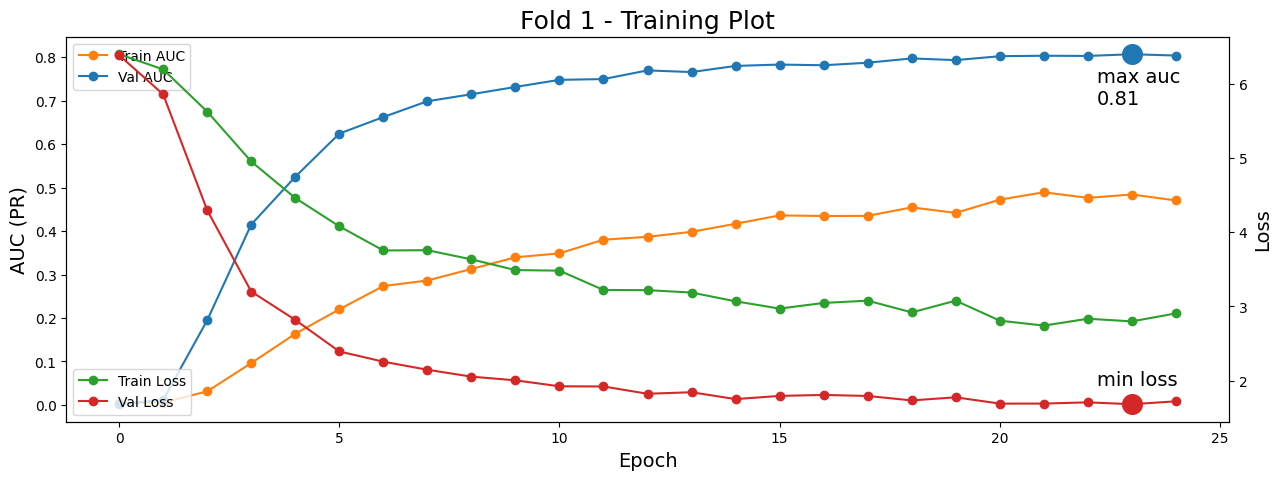

In [44]:
# Configurations
num_classes = CFG.num_classes2
df = df_pre.copy()
fold = 0

# Compute batch size and number of samples to drop
infer_bs = (CFG.batch_size*CFG.infer_bs)
drop_remainder = CFG.drop_remainder

# Split dataset with cv filter
if CFG.cv_filter:
    df = filter_data(df, thr=5)
    train_df = df.query("fold!=@fold | ~cv").reset_index(drop=True)
    valid_df = df.query("fold==@fold & cv").reset_index(drop=True)
else:
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)

# Upsample train data
train_df = upsample_data(train_df, thr=50)
train_df = downsample_data(train_df, thr=500)

# Get file paths and labels
train_paths = train_df.filepath.values; train_labels = train_df.target.values
valid_paths = valid_df.filepath.values; valid_labels = valid_df.target.values

# Shuffle the file paths and labels
index = np.arange(len(train_paths))
np.random.shuffle(index)
train_paths  = train_paths[index]
train_labels = train_labels[index]

# For debugging
if CFG.debug:
    min_samples = CFG.batch_size*CFG.replicas*2
    train_paths = train_paths[:min_samples]; train_labels = train_labels[:min_samples]
    valid_paths = valid_paths[:min_samples]; valid_labels = valid_labels[:min_samples]
    
# Ogg or Mp3
train_ftype = list(map(lambda x: '.ogg' in x, train_paths))
valid_ftype = list(map(lambda x: '.ogg' in x, valid_paths))

# Compute the number of training and validation samples
num_train = len(train_paths); num_valid = len(valid_paths)

# Build the training and validation datasets
cache=False
train_ds = build_dataset(train_paths, train_ftype, train_labels, 
                         batch_size=CFG.batch_size*CFG.replicas, cache=cache, shuffle=True,
                        drop_remainder=drop_remainder, num_classes=num_classes)
valid_ds = build_dataset(valid_paths, valid_ftype, valid_labels,
                         batch_size=CFG.batch_size*CFG.replicas, cache=True, shuffle=False,
                         augment=False, repeat=False, drop_remainder=drop_remainder,
                         take_first=True, num_classes=num_classes)

# Print information about the fold and training
print('#'*25); print('#### Pre-Training')
print('#### Image Size: (%i, %i) | Model: %s | Batch Size: %i | Scheduler: %s'%
      (*CFG.img_size, CFG.model_name, CFG.batch_size*CFG.replicas, CFG.scheduler))
print('#### Num Train: {:,} | Num Valid: {:,}'.format(len(train_paths), len(valid_paths)))

# Clear the session and build the model
K.clear_session()
with strategy.scope():
    model = build_model(CFG, model_name=CFG.model_name, num_classes=num_classes)

print('#'*25) 

# Checkpoint Callback
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    'birdclef_pretrained_ckpt.h5', monitor='val_auc', verbose=0, save_best_only=True,
    save_weights_only=False, mode='max', save_freq='epoch')
# LR Scheduler Callback
lr_cb = get_lr_callback(CFG.batch_size*CFG.replicas)
callbacks = [ckpt_cb, lr_cb]

# Training
history = model.fit(
    train_ds, 
    epochs=2 if CFG.debug else CFG.epochs, 
    callbacks=callbacks, 
    steps_per_epoch=len(train_paths)/CFG.batch_size//CFG.replicas,
    validation_data=valid_ds, 
    verbose=CFG.verbose,
)

# Show training plot
if CFG.training_plot:
    plot_history(history)

# Training 🚄
In this stage model will be trained on BirdCLEF 23 data. But initial checkpoint will be from pre-trained model.

wandb: Currently logged in as: awsaf49. Use `wandb login --relogin` to force relogin


#########################
#### Training
#### Fold: 1 | Image Size: (128, 384) | Model: EfficientNetB1 | Batch Size: 256 | Scheduler: cos
#### Num Train: 19,627 | Num Valid: 3,381


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


#########################


2023-04-07 08:36:12.790816: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_602/ReadVariableOp.


2023-04-07 08:36:14.126234: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_602/ReadVariableOp.


2023-04-07 08:39:08.904591: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.


2023-04-07 08:39:09.149223: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.


# Loading best model


# Infering OOF


2023-04-07 08:51:33.537253: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


2023-04-07 08:51:33.848421: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.



>>> FOLD 1 OOF AUC = 0.837 | Padded_cmAP = 0.898


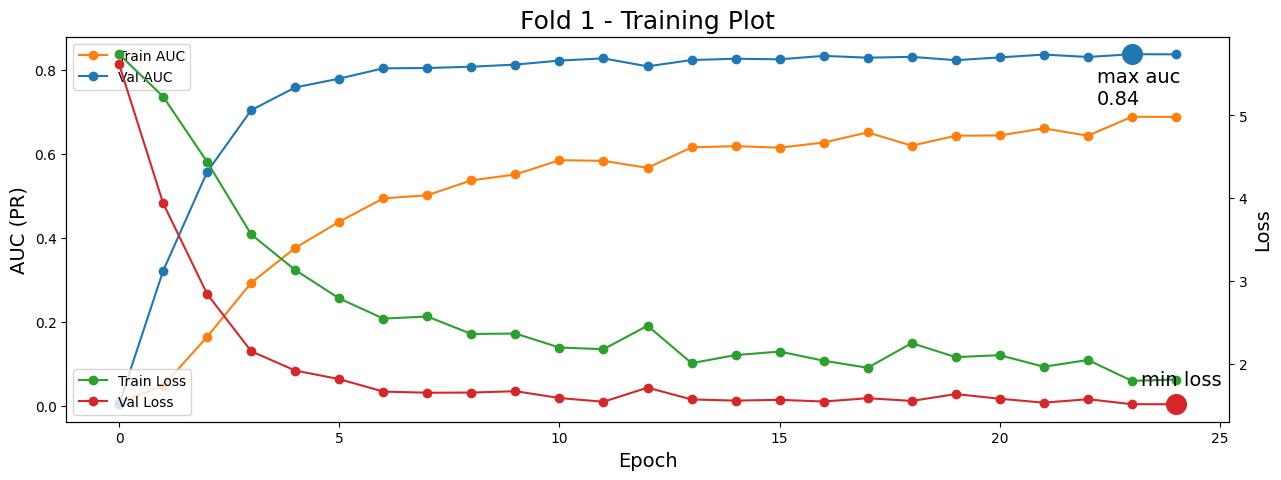

# WandB


wandb :   0%|          | 0/701 [00:00<?, ?it/s]

wandb :   0%|          | 2/701 [00:00<00:56, 12.44it/s]

wandb :   1%|          | 5/701 [00:00<00:35, 19.59it/s]

wandb :   1%|          | 8/701 [00:00<01:03, 10.87it/s]

wandb :   1%|▏         | 10/701 [00:00<01:05, 10.54it/s]

wandb :   2%|▏         | 13/701 [00:01<01:01, 11.16it/s]

wandb :   2%|▏         | 16/701 [00:01<00:54, 12.56it/s]

wandb :   3%|▎         | 18/701 [00:01<00:57, 11.98it/s]

wandb :   3%|▎         | 21/701 [00:01<00:45, 14.85it/s]

wandb :   3%|▎         | 23/701 [00:01<00:43, 15.64it/s]

wandb :   4%|▎         | 25/701 [00:01<00:44, 15.27it/s]

wandb :   4%|▍         | 27/701 [00:02<00:49, 13.49it/s]

wandb :   4%|▍         | 30/701 [00:02<00:40, 16.56it/s]

wandb :   5%|▍         | 32/701 [00:02<00:47, 13.98it/s]

wandb :   5%|▍         | 34/701 [00:02<00:45, 14.79it/s]

wandb :   5%|▌         | 36/701 [00:02<00:50, 13.22it/s]

wandb :   6%|▌         | 39/701 [00:02<00:41, 15.91it/s]

wandb :   6%|▌         | 41/701 [00:02<00:42, 15.55it/s]

wandb :   6%|▌         | 43/701 [00:03<00:55, 11.79it/s]

wandb :   6%|▋         | 45/701 [00:03<00:53, 12.28it/s]

wandb :   7%|▋         | 47/701 [00:03<00:51, 12.76it/s]

wandb :   7%|▋         | 49/701 [00:03<00:52, 12.47it/s]

wandb :   7%|▋         | 52/701 [00:03<00:45, 14.31it/s]

wandb :   8%|▊         | 55/701 [00:03<00:39, 16.47it/s]

wandb :   8%|▊         | 57/701 [00:04<00:38, 16.77it/s]

wandb :   8%|▊         | 59/701 [00:04<00:38, 16.61it/s]

wandb :   9%|▊         | 61/701 [00:04<00:42, 15.12it/s]

wandb :   9%|▉         | 63/701 [00:04<00:44, 14.32it/s]

wandb :  10%|▉         | 67/701 [00:04<00:33, 19.07it/s]

wandb :  10%|▉         | 70/701 [00:05<01:08,  9.21it/s]

wandb :  10%|█         | 72/701 [00:05<00:59, 10.51it/s]

wandb :  11%|█         | 74/701 [00:05<00:57, 10.83it/s]

wandb :  11%|█         | 77/701 [00:05<00:45, 13.57it/s]

wandb :  11%|█▏        | 80/701 [00:05<00:42, 14.70it/s]

wandb :  12%|█▏        | 82/701 [00:07<02:47,  3.69it/s]

wandb :  12%|█▏        | 84/701 [00:07<02:13,  4.62it/s]

wandb :  12%|█▏        | 86/701 [00:08<02:04,  4.96it/s]

wandb :  13%|█▎        | 89/701 [00:08<01:28,  6.90it/s]

wandb :  13%|█▎        | 91/701 [00:08<01:17,  7.91it/s]

wandb :  13%|█▎        | 93/701 [00:08<01:06,  9.12it/s]

wandb :  14%|█▎        | 95/701 [00:08<01:17,  7.85it/s]

wandb :  14%|█▍        | 97/701 [00:09<01:07,  8.98it/s]

wandb :  14%|█▍        | 101/701 [00:09<00:52, 11.46it/s]

wandb :  15%|█▍        | 103/701 [00:09<00:50, 11.92it/s]

wandb :  15%|█▌        | 106/701 [00:09<00:44, 13.31it/s]

wandb :  15%|█▌        | 108/701 [00:09<00:57, 10.39it/s]

wandb :  16%|█▌        | 110/701 [00:10<00:54, 10.93it/s]

wandb :  16%|█▌        | 112/701 [00:10<00:48, 12.21it/s]

wandb :  16%|█▋        | 114/701 [00:10<00:53, 10.89it/s]

wandb :  17%|█▋        | 117/701 [00:10<00:43, 13.31it/s]

wandb :  17%|█▋        | 119/701 [00:10<00:40, 14.37it/s]

wandb :  17%|█▋        | 121/701 [00:10<00:39, 14.50it/s]

wandb :  18%|█▊        | 124/701 [00:10<00:35, 16.20it/s]

wandb :  18%|█▊        | 126/701 [00:11<00:40, 14.16it/s]

wandb :  18%|█▊        | 129/701 [00:11<00:35, 16.21it/s]

wandb :  19%|█▊        | 131/701 [00:11<00:45, 12.41it/s]

wandb :  19%|█▉        | 133/701 [00:11<00:48, 11.81it/s]

wandb :  19%|█▉        | 135/701 [00:11<00:50, 11.11it/s]

wandb :  20%|█▉        | 137/701 [00:12<00:50, 11.13it/s]

wandb :  20%|█▉        | 140/701 [00:12<00:47, 11.92it/s]

wandb :  20%|██        | 142/701 [00:12<00:42, 13.28it/s]

wandb :  21%|██        | 144/701 [00:12<00:43, 12.71it/s]

wandb :  21%|██        | 147/701 [00:12<00:36, 15.06it/s]

wandb :  21%|██▏       | 149/701 [00:13<01:02,  8.90it/s]

wandb :  22%|██▏       | 152/701 [00:13<00:56,  9.75it/s]

wandb :  22%|██▏       | 155/701 [00:13<00:54, 10.03it/s]

wandb :  22%|██▏       | 157/701 [00:13<00:48, 11.22it/s]

wandb :  23%|██▎       | 159/701 [00:14<00:49, 10.90it/s]

wandb :  23%|██▎       | 162/701 [00:14<00:41, 13.08it/s]

wandb :  23%|██▎       | 164/701 [00:14<00:37, 14.21it/s]

wandb :  24%|██▍       | 167/701 [00:14<00:31, 17.00it/s]

wandb :  24%|██▍       | 169/701 [00:14<00:31, 16.92it/s]

wandb :  24%|██▍       | 171/701 [00:15<01:13,  7.21it/s]

wandb :  25%|██▍       | 173/701 [00:15<01:03,  8.27it/s]

wandb :  25%|██▍       | 175/701 [00:15<01:04,  8.20it/s]

wandb :  25%|██▌       | 177/701 [00:15<00:58,  8.99it/s]

wandb :  26%|██▌       | 179/701 [00:15<00:50, 10.42it/s]

wandb :  26%|██▌       | 181/701 [00:16<00:50, 10.36it/s]

wandb :  26%|██▌       | 184/701 [00:16<00:40, 12.80it/s]

wandb :  27%|██▋       | 187/701 [00:16<00:32, 15.85it/s]

wandb :  27%|██▋       | 190/701 [00:16<00:29, 17.12it/s]

wandb :  27%|██▋       | 192/701 [00:16<00:33, 15.41it/s]

wandb :  28%|██▊       | 194/701 [00:17<00:41, 12.17it/s]

wandb :  28%|██▊       | 197/701 [00:17<00:34, 14.66it/s]

wandb :  28%|██▊       | 199/701 [00:17<00:32, 15.60it/s]

wandb :  29%|██▉       | 202/701 [00:17<00:26, 18.60it/s]

wandb :  29%|██▉       | 205/701 [00:17<00:25, 19.24it/s]

wandb :  30%|██▉       | 208/701 [00:17<00:35, 13.93it/s]

wandb :  30%|██▉       | 210/701 [00:18<00:37, 13.09it/s]

wandb :  30%|███       | 212/701 [00:18<00:36, 13.33it/s]

wandb :  31%|███       | 214/701 [00:18<00:34, 13.92it/s]

wandb :  31%|███       | 217/701 [00:18<00:29, 16.67it/s]

wandb :  31%|███       | 219/701 [00:18<00:36, 13.22it/s]

wandb :  32%|███▏      | 223/701 [00:18<00:28, 16.66it/s]

wandb :  32%|███▏      | 225/701 [00:19<00:35, 13.25it/s]

wandb :  32%|███▏      | 227/701 [00:19<00:35, 13.51it/s]

wandb :  33%|███▎      | 229/701 [00:19<00:34, 13.70it/s]

wandb :  33%|███▎      | 231/701 [00:19<00:37, 12.65it/s]

wandb :  33%|███▎      | 233/701 [00:19<00:34, 13.54it/s]

wandb :  34%|███▎      | 235/701 [00:19<00:33, 13.80it/s]

wandb :  34%|███▍      | 238/701 [00:19<00:30, 15.42it/s]

wandb :  34%|███▍      | 241/701 [00:20<00:29, 15.81it/s]

wandb :  35%|███▍      | 244/701 [00:20<00:27, 16.88it/s]

wandb :  35%|███▌      | 246/701 [00:20<00:33, 13.62it/s]

wandb :  35%|███▌      | 248/701 [00:20<00:49,  9.06it/s]

wandb :  36%|███▌      | 250/701 [00:21<00:45, 10.01it/s]

wandb :  36%|███▌      | 252/701 [00:21<00:40, 11.22it/s]

wandb :  37%|███▋      | 257/701 [00:21<00:33, 13.34it/s]

wandb :  37%|███▋      | 259/701 [00:21<00:32, 13.47it/s]

wandb :  37%|███▋      | 261/701 [00:21<00:36, 12.01it/s]

wandb :  38%|███▊      | 263/701 [00:22<00:38, 11.39it/s]

wandb :  38%|███▊      | 265/701 [00:22<00:35, 12.12it/s]

wandb :  38%|███▊      | 267/701 [00:22<00:32, 13.16it/s]

wandb :  38%|███▊      | 269/701 [00:22<00:34, 12.60it/s]

wandb :  39%|███▊      | 271/701 [00:22<00:41, 10.38it/s]

wandb :  39%|███▉      | 273/701 [00:22<00:41, 10.34it/s]

wandb :  39%|███▉      | 275/701 [00:23<00:35, 11.98it/s]

wandb :  40%|███▉      | 277/701 [00:23<00:34, 12.14it/s]

wandb :  40%|███▉      | 279/701 [00:23<00:34, 12.41it/s]

wandb :  40%|████      | 282/701 [00:23<00:27, 15.39it/s]

wandb :  41%|████      | 284/701 [00:23<00:32, 12.66it/s]

wandb :  41%|████      | 286/701 [00:23<00:30, 13.60it/s]

wandb :  41%|████      | 289/701 [00:24<00:26, 15.70it/s]

wandb :  42%|████▏     | 291/701 [00:24<00:25, 16.05it/s]

wandb :  42%|████▏     | 293/701 [00:24<00:24, 16.71it/s]

wandb :  42%|████▏     | 296/701 [00:24<00:21, 19.06it/s]

wandb :  43%|████▎     | 301/701 [00:24<00:19, 20.59it/s]

wandb :  43%|████▎     | 304/701 [00:24<00:22, 17.92it/s]

wandb :  44%|████▍     | 307/701 [00:24<00:20, 19.39it/s]

wandb :  44%|████▍     | 310/701 [00:25<00:20, 18.89it/s]

wandb :  45%|████▍     | 312/701 [00:25<00:20, 19.00it/s]

wandb :  45%|████▍     | 314/701 [00:25<00:26, 14.86it/s]

wandb :  45%|████▌     | 316/701 [00:25<00:31, 12.25it/s]

wandb :  45%|████▌     | 318/701 [00:25<00:30, 12.67it/s]

wandb :  46%|████▌     | 320/701 [00:25<00:27, 13.69it/s]

wandb :  46%|████▌     | 323/701 [00:26<00:22, 16.87it/s]

wandb :  47%|████▋     | 327/701 [00:26<00:20, 18.11it/s]

wandb :  47%|████▋     | 329/701 [00:26<00:20, 18.13it/s]

wandb :  47%|████▋     | 332/701 [00:26<00:32, 11.22it/s]

wandb :  48%|████▊     | 334/701 [00:26<00:31, 11.57it/s]

wandb :  48%|████▊     | 337/701 [00:27<00:25, 14.48it/s]

wandb :  48%|████▊     | 339/701 [00:27<00:32, 11.22it/s]

wandb :  49%|████▊     | 341/701 [00:27<00:29, 12.31it/s]

wandb :  49%|████▉     | 343/701 [00:27<00:30, 11.61it/s]

wandb :  49%|████▉     | 345/701 [00:27<00:29, 12.23it/s]

wandb :  50%|████▉     | 348/701 [00:27<00:24, 14.62it/s]

wandb :  50%|█████     | 351/701 [00:28<00:21, 16.40it/s]

wandb :  50%|█████     | 353/701 [00:28<00:21, 15.85it/s]

wandb :  51%|█████     | 355/701 [00:28<00:23, 14.86it/s]

wandb :  51%|█████     | 357/701 [00:28<00:39,  8.60it/s]

wandb :  51%|█████     | 359/701 [00:29<00:36,  9.27it/s]

wandb :  51%|█████▏    | 361/701 [00:29<00:32, 10.33it/s]

wandb :  52%|█████▏    | 363/701 [00:29<00:42,  7.90it/s]

wandb :  52%|█████▏    | 365/701 [00:29<00:39,  8.51it/s]

wandb :  52%|█████▏    | 367/701 [00:29<00:34,  9.78it/s]

wandb :  53%|█████▎    | 369/701 [00:30<00:29, 11.14it/s]

wandb :  53%|█████▎    | 373/701 [00:30<00:20, 16.04it/s]

wandb :  54%|█████▎    | 376/701 [00:30<00:19, 16.37it/s]

wandb :  54%|█████▍    | 379/701 [00:30<00:17, 18.44it/s]

wandb :  54%|█████▍    | 382/701 [00:30<00:15, 19.99it/s]

wandb :  55%|█████▍    | 385/701 [00:30<00:14, 21.30it/s]

wandb :  55%|█████▌    | 388/701 [00:31<00:42,  7.40it/s]

wandb :  56%|█████▌    | 391/701 [00:31<00:32,  9.58it/s]

wandb :  56%|█████▌    | 394/701 [00:32<00:28, 10.83it/s]

wandb :  56%|█████▋    | 396/701 [00:32<00:27, 11.08it/s]

wandb :  57%|█████▋    | 398/701 [00:32<00:25, 11.74it/s]

wandb :  57%|█████▋    | 400/701 [00:32<00:33,  9.09it/s]

wandb :  57%|█████▋    | 402/701 [00:33<00:36,  8.25it/s]

wandb :  58%|█████▊    | 404/701 [00:33<00:30,  9.71it/s]

wandb :  58%|█████▊    | 406/701 [00:33<00:26, 11.10it/s]

wandb :  58%|█████▊    | 408/701 [00:33<00:27, 10.69it/s]

wandb :  58%|█████▊    | 410/701 [00:34<00:50,  5.78it/s]

wandb :  59%|█████▉    | 413/701 [00:34<00:35,  8.21it/s]

wandb :  59%|█████▉    | 415/701 [00:34<00:30,  9.29it/s]

wandb :  59%|█████▉    | 417/701 [00:34<00:27, 10.18it/s]

wandb :  60%|█████▉    | 420/701 [00:34<00:20, 13.44it/s]

wandb :  60%|██████    | 422/701 [00:34<00:22, 12.38it/s]

wandb :  60%|██████    | 424/701 [00:34<00:20, 13.82it/s]

wandb :  61%|██████    | 427/701 [00:35<00:20, 13.34it/s]

wandb :  61%|██████    | 429/701 [00:35<00:21, 12.81it/s]

wandb :  62%|██████▏   | 432/701 [00:35<00:20, 13.22it/s]

wandb :  62%|██████▏   | 434/701 [00:35<00:19, 13.55it/s]

wandb :  62%|██████▏   | 436/701 [00:35<00:19, 13.52it/s]

wandb :  63%|██████▎   | 439/701 [00:35<00:15, 16.51it/s]

wandb :  63%|██████▎   | 441/701 [00:36<00:19, 13.12it/s]

wandb :  63%|██████▎   | 443/701 [00:36<00:19, 13.25it/s]

wandb :  64%|██████▎   | 446/701 [00:36<00:15, 16.42it/s]

wandb :  64%|██████▍   | 449/701 [00:36<00:13, 18.80it/s]

wandb :  64%|██████▍   | 452/701 [00:36<00:13, 18.29it/s]

wandb :  65%|██████▍   | 455/701 [00:36<00:12, 19.45it/s]

wandb :  65%|██████▌   | 458/701 [00:37<00:13, 17.94it/s]

wandb :  66%|██████▌   | 460/701 [00:37<00:13, 17.62it/s]

wandb :  66%|██████▌   | 463/701 [00:37<00:12, 18.79it/s]

wandb :  66%|██████▋   | 465/701 [00:37<00:12, 18.38it/s]

wandb :  67%|██████▋   | 467/701 [00:37<00:17, 13.37it/s]

wandb :  67%|██████▋   | 469/701 [00:37<00:20, 11.43it/s]

wandb :  67%|██████▋   | 471/701 [00:38<00:19, 12.10it/s]

wandb :  67%|██████▋   | 473/701 [00:38<00:21, 10.50it/s]

wandb :  68%|██████▊   | 476/701 [00:38<00:17, 12.78it/s]

wandb :  68%|██████▊   | 478/701 [00:38<00:17, 12.86it/s]

wandb :  68%|██████▊   | 480/701 [00:38<00:17, 12.73it/s]

wandb :  69%|██████▉   | 483/701 [00:39<00:14, 14.65it/s]

wandb :  69%|██████▉   | 485/701 [00:39<00:16, 12.98it/s]

wandb :  69%|██████▉   | 487/701 [00:39<00:16, 12.93it/s]

wandb :  70%|███████   | 491/701 [00:39<00:12, 17.47it/s]

wandb :  70%|███████   | 494/701 [00:39<00:10, 19.66it/s]

wandb :  71%|███████   | 497/701 [00:39<00:10, 20.28it/s]

wandb :  71%|███████▏  | 500/701 [00:40<00:14, 13.56it/s]

wandb :  72%|███████▏  | 502/701 [00:40<00:13, 14.35it/s]

wandb :  72%|███████▏  | 504/701 [00:40<00:13, 14.67it/s]

wandb :  72%|███████▏  | 507/701 [00:40<00:11, 16.87it/s]

wandb :  73%|███████▎  | 509/701 [00:40<00:13, 14.43it/s]

wandb :  73%|███████▎  | 511/701 [00:40<00:12, 14.73it/s]

wandb :  73%|███████▎  | 513/701 [00:40<00:11, 15.68it/s]

wandb :  73%|███████▎  | 515/701 [00:41<00:12, 15.04it/s]

wandb :  74%|███████▍  | 517/701 [00:41<00:12, 14.85it/s]

wandb :  74%|███████▍  | 520/701 [00:41<00:10, 16.54it/s]

wandb :  74%|███████▍  | 522/701 [00:41<00:13, 13.28it/s]

wandb :  75%|███████▍  | 524/701 [00:41<00:14, 12.51it/s]

wandb :  75%|███████▌  | 526/701 [00:41<00:13, 12.63it/s]

wandb :  75%|███████▌  | 528/701 [00:42<00:12, 14.08it/s]

wandb :  76%|███████▌  | 530/701 [00:42<00:11, 14.42it/s]

wandb :  76%|███████▌  | 532/701 [00:42<00:14, 11.89it/s]

wandb :  76%|███████▋  | 535/701 [00:42<00:11, 14.12it/s]

wandb :  77%|███████▋  | 537/701 [00:42<00:11, 14.29it/s]

wandb :  77%|███████▋  | 539/701 [00:42<00:10, 15.45it/s]

wandb :  77%|███████▋  | 541/701 [00:42<00:10, 15.30it/s]

wandb :  77%|███████▋  | 543/701 [00:43<00:10, 14.78it/s]

wandb :  78%|███████▊  | 546/701 [00:43<00:08, 18.17it/s]

wandb :  78%|███████▊  | 549/701 [00:43<00:07, 20.83it/s]

wandb :  79%|███████▊  | 552/701 [00:43<00:07, 20.37it/s]

wandb :  79%|███████▉  | 555/701 [00:43<00:08, 18.19it/s]

wandb :  79%|███████▉  | 557/701 [00:43<00:09, 15.23it/s]

wandb :  80%|███████▉  | 559/701 [00:44<00:12, 11.32it/s]

wandb :  80%|████████  | 561/701 [00:44<00:15,  8.93it/s]

wandb :  80%|████████  | 563/701 [00:44<00:14,  9.49it/s]

wandb :  81%|████████  | 565/701 [00:44<00:15,  8.56it/s]

wandb :  81%|████████  | 569/701 [00:45<00:10, 13.12it/s]

wandb :  82%|████████▏ | 572/701 [00:45<00:08, 15.91it/s]

wandb :  82%|████████▏ | 576/701 [00:45<00:07, 17.16it/s]

wandb :  83%|████████▎ | 579/701 [00:45<00:08, 14.94it/s]

wandb :  83%|████████▎ | 581/701 [00:45<00:08, 13.46it/s]

wandb :  83%|████████▎ | 583/701 [00:46<00:08, 13.39it/s]

wandb :  84%|████████▎ | 586/701 [00:46<00:07, 14.70it/s]

wandb :  84%|████████▍ | 589/701 [00:46<00:07, 15.26it/s]

wandb :  84%|████████▍ | 591/701 [00:46<00:07, 14.32it/s]

wandb :  85%|████████▍ | 593/701 [00:46<00:10, 10.58it/s]

wandb :  85%|████████▍ | 595/701 [00:47<00:10, 10.35it/s]

wandb :  85%|████████▌ | 597/701 [00:47<00:10, 10.12it/s]

wandb :  85%|████████▌ | 599/701 [00:47<00:12,  8.43it/s]

wandb :  86%|████████▌ | 602/701 [00:47<00:09,  9.98it/s]

wandb :  86%|████████▌ | 604/701 [00:48<00:09,  9.76it/s]

wandb :  86%|████████▋ | 606/701 [00:48<00:09, 10.46it/s]

wandb :  87%|████████▋ | 608/701 [00:48<00:09, 10.30it/s]

wandb :  87%|████████▋ | 610/701 [00:48<00:08, 11.01it/s]

wandb :  87%|████████▋ | 612/701 [00:48<00:07, 12.09it/s]

wandb :  88%|████████▊ | 614/701 [00:48<00:08,  9.87it/s]

wandb :  88%|████████▊ | 616/701 [00:49<00:08,  9.92it/s]

wandb :  88%|████████▊ | 618/701 [00:49<00:07, 10.43it/s]

wandb :  88%|████████▊ | 620/701 [00:49<00:08,  9.15it/s]

wandb :  89%|████████▊ | 621/701 [00:49<00:08,  9.25it/s]

wandb :  89%|████████▉ | 623/701 [00:49<00:06, 11.22it/s]

wandb :  89%|████████▉ | 625/701 [00:49<00:06, 11.03it/s]

wandb :  89%|████████▉ | 627/701 [00:50<00:06, 11.77it/s]

wandb :  90%|████████▉ | 629/701 [00:50<00:06, 10.94it/s]

wandb :  90%|█████████ | 631/701 [00:50<00:06, 10.73it/s]

wandb :  90%|█████████ | 633/701 [00:50<00:05, 11.45it/s]

wandb :  91%|█████████ | 635/701 [00:50<00:05, 12.87it/s]

wandb :  91%|█████████ | 637/701 [00:50<00:04, 14.05it/s]

wandb :  91%|█████████ | 639/701 [00:51<00:04, 13.97it/s]

wandb :  91%|█████████▏| 641/701 [00:51<00:04, 14.09it/s]

wandb :  92%|█████████▏| 643/701 [00:51<00:03, 15.05it/s]

wandb :  92%|█████████▏| 645/701 [00:51<00:05, 10.89it/s]

wandb :  92%|█████████▏| 647/701 [00:51<00:04, 11.35it/s]

wandb :  93%|█████████▎| 650/701 [00:51<00:03, 14.62it/s]

wandb :  93%|█████████▎| 652/701 [00:52<00:03, 14.19it/s]

wandb :  93%|█████████▎| 654/701 [00:52<00:03, 12.55it/s]

wandb :  94%|█████████▎| 656/701 [00:52<00:03, 12.82it/s]

wandb :  94%|█████████▍| 659/701 [00:52<00:03, 12.96it/s]

wandb :  94%|█████████▍| 661/701 [00:52<00:02, 13.96it/s]

wandb :  95%|█████████▍| 663/701 [00:52<00:02, 14.86it/s]

wandb :  95%|█████████▍| 665/701 [00:52<00:02, 15.80it/s]

wandb :  95%|█████████▌| 667/701 [00:53<00:02, 15.29it/s]

wandb :  95%|█████████▌| 669/701 [00:53<00:02, 15.08it/s]

wandb :  96%|█████████▌| 671/701 [00:53<00:01, 15.18it/s]

wandb :  96%|█████████▌| 674/701 [00:53<00:01, 16.25it/s]

wandb :  96%|█████████▋| 676/701 [00:53<00:01, 15.65it/s]

wandb :  97%|█████████▋| 678/701 [00:53<00:01, 13.15it/s]

wandb :  97%|█████████▋| 680/701 [00:53<00:01, 14.22it/s]

wandb :  97%|█████████▋| 683/701 [00:54<00:01, 11.67it/s]

wandb :  98%|█████████▊| 685/701 [00:54<00:01, 12.92it/s]

wandb :  98%|█████████▊| 688/701 [00:54<00:00, 15.79it/s]

wandb :  98%|█████████▊| 690/701 [00:54<00:00, 15.08it/s]

wandb :  99%|█████████▊| 692/701 [00:54<00:00, 16.11it/s]

wandb :  99%|█████████▉| 694/701 [00:54<00:00, 16.08it/s]

wandb :  99%|█████████▉| 697/701 [00:55<00:00, 17.40it/s]

wandb : 100%|█████████▉| 699/701 [00:55<00:00, 13.72it/s]

wandb : 100%|██████████| 701/701 [00:55<00:00, 14.36it/s]

wandb : 100%|██████████| 701/701 [00:55<00:00, 12.65it/s]

In [45]:
oof_pred = []; oof_true = []; oof_val = []; oof_ids = []; oof_folds = [] 

num_classes = CFG.num_classes
df = df_23.copy()
for fold in range(CFG.num_fold):
    # Check if the fold is selected
    if fold not in CFG.selected_folds:
        continue
    
    # Initialize Weights and Biases
    if CFG.wandb:
        run = wandb_init(fold)
    
    # Compute batch size and number of samples to drop
    infer_bs = (CFG.batch_size*CFG.infer_bs)
    drop_remainder = CFG.drop_remainder
    
    # Split dataset with cv filter
    if CFG.cv_filter:
        df = filter_data(df, thr=5)
        train_df = df.query("fold!=@fold | ~cv").reset_index(drop=True)
        valid_df = df.query("fold==@fold & cv").reset_index(drop=True)
    else:
        train_df = df.query("fold!=@fold").reset_index(drop=True)
        valid_df = df.query("fold==@fold").reset_index(drop=True)
    
    # Upsample train data
    train_df = upsample_data(train_df, thr=50)
#     train_df = downsample_data(train_df, thr=500)

    # Get file paths and labels
    train_paths = train_df.filepath.values; train_labels = train_df.target.values
    valid_paths = valid_df.filepath.values; valid_labels = valid_df.target.values

    # Shuffle the file paths and labels
    index = np.arange(len(train_paths))
    np.random.shuffle(index)
    train_paths  = train_paths[index]
    train_labels = train_labels[index]
    
    # For debugging
    if CFG.debug:
        min_samples = CFG.batch_size*CFG.replicas*2
        train_paths = train_paths[:min_samples]; train_labels = train_labels[:min_samples]
        valid_paths = valid_paths[:min_samples]; valid_labels = valid_labels[:min_samples]

    # Ogg or Mp3
    train_ftype = list(map(lambda x: '.ogg' in x, train_paths))
    valid_ftype = list(map(lambda x: '.ogg' in x, valid_paths))

    # Compute the number of training and validation samples
    num_train = len(train_paths); num_valid = len(valid_paths)
        
    # Log the number of training and validation samples if Weights and Biases is being used
    if CFG.wandb:
        wandb.log({'num_train':num_train,
                   'num_valid':num_valid})
        
    # Build the training and validation datasets
    cache=True
    train_ds = build_dataset(train_paths, train_ftype, train_labels, 
                             batch_size=CFG.batch_size*CFG.replicas, cache=cache, shuffle=True,
                            drop_remainder=drop_remainder, num_classes=num_classes)
    valid_ds = build_dataset(valid_paths, valid_ftype, valid_labels,
                             batch_size=CFG.batch_size*CFG.replicas, cache=cache, shuffle=False,
                             augment=False, repeat=False, drop_remainder=drop_remainder,
                             take_first=True, num_classes=num_classes)
    
    # Print information about the fold and training
    print('#'*25); print('#### Training')
    print('#### Fold: %i | Image Size: (%i, %i) | Model: %s | Batch Size: %i | Scheduler: %s'%
          (fold+1, *CFG.img_size, CFG.model_name, CFG.batch_size*CFG.replicas, CFG.scheduler))
    print('#### Num Train: {:,} | Num Valid: {:,}'.format(len(train_paths), len(valid_paths)))
    
    # Clear the session and build the model
    K.clear_session()
    with strategy.scope():
        model = build_model(CFG, model_name=CFG.model_name, num_classes=num_classes)
    # Load birdclef pretrained weights
    model.load_weights("birdclef_pretrained_ckpt.h5", by_name=True, skip_mismatch=True)
        
    print('#'*25) 
    
    # Callbacks
    ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_auc', verbose=0, save_best_only=True,
        save_weights_only=False, mode='max', save_freq='epoch')
    # LR Scheduler Callback
    lr_cb = get_lr_callback(CFG.batch_size*CFG.replicas)
    callbacks = [ckpt_cb, lr_cb]
    # WandB Callbacks
    if CFG.wandb:
        wb_cb = get_wb_callbacks(fold)
        callbacks+=[wb_cb]

    # Training
    history = model.fit(
        train_ds, 
        epochs=2 if CFG.debug else CFG.epochs, 
        callbacks=callbacks, 
        steps_per_epoch=len(train_paths)/CFG.batch_size//CFG.replicas,
        validation_data=valid_ds, 
        verbose=CFG.verbose,
    )
    
    # Load best checkpoint
    print('# Loading best model')
    model.load_weights('fold-%i.h5'%fold)
    
    # Predict on the validation data for oof result
    print('# Infering OOF')
    valid_ds = build_dataset(valid_paths, valid_ftype, labels=None, augment=CFG.tta>1, repeat=True, cache=False, 
                             shuffle=False, batch_size=infer_bs*CFG.replicas, 
                             drop_remainder=drop_remainder, take_first=True, num_classes=num_classes)
    ct_valid = len(valid_paths); STEPS = CFG.tta * ct_valid/infer_bs/CFG.replicas
    pred = model.predict(valid_ds,steps=STEPS,verbose=CFG.verbose)[:CFG.tta*ct_valid,] 
    pred = np.mean(pred.reshape((CFG.tta,ct_valid,-1)),axis=0)
    oof_pred.append(pred)               

    # Get ids and targets
    oof_true.append(valid_df[CFG.target_col].values[:ct_valid])
    oof_folds.append(np.ones_like(oof_true[-1],dtype='int8')*fold )
    oof_ids.append(valid_paths)
   
    # Save valid data prediction
    y_true = oof_true[-1].reshape(-1).astype('float32')
    y_pred = oof_pred[-1].argmax(axis=-1)
    valid_df.loc[:num_valid - 1, 'pred'] = y_pred
    valid_df.loc[:num_valid - 1, 'miss'] = y_true != y_pred
    valid_df.loc[:num_valid - 1, CFG.class_names] = oof_pred[-1].tolist()
    
    # Log the metrics
    scores = {}
    cmAP = padded_cmap(tf.keras.utils.to_categorical(y_true), oof_pred[-1])
    best_epoch = np.argmax(history.history['val_'+CFG.monitor], axis=-1) + 1
    best_score = history.history['val_'+CFG.monitor][best_epoch - 1]
    scores.update({'auc': best_score,
                   'epoch': best_epoch,
                   'cmAP': cmAP,})
    oof_val.append(best_score)
    print('\n>>> FOLD %i OOF AUC = %.3f | Padded_cmAP = %.3f' % (fold+1, oof_val[-1], cmAP))
    
    # Show training plot
    if CFG.training_plot:
        plot_history(history)
        
    # Log metrics, media to wandb
    if CFG.wandb:
        print('# WandB')
        log_wandb(valid_df)
        wandb.run.finish()
        display(ipd.IFrame(run.url, width=1080, height=720))

## Training Log
### [Click Here ➡️](https://wandb.ai/awsaf49/birdclef-2023-public) to check training log in **WandB** dashboard.

<img src="https://i.postimg.cc/Pxg61FhY/wandb-dashboard-birdclef23.png">

# Performance 🎭
In the following section we'll look into our overall score of `cmAP`

In [46]:
def get_id(row):
    row['filename'] = row['filepath'].split('/',5)[-1]
    return row

In [47]:
# OOF Data
y_pred = np.concatenate(oof_pred); y_true = np.concatenate(oof_true);
ids = np.concatenate(oof_ids); folds = np.concatenate(oof_folds)

# Overall cmAP
cmAP = padded_cmap(tf.keras.utils.to_categorical(y_true), y_pred)

# Overall AUC in PR curve
m = tf.keras.metrics.AUC(curve='PR')
m.update_state(tf.keras.utils.to_categorical(y_true), y_pred)
auc = m.result().numpy()

print('>>> Overall cmAP: ', cmAP)
print('>>> Overall AUC(PR): ', auc)

>>> Overall cmAP:  0.897516964644032
>>> Overall AUC(PR):  0.83705264


## Save OOF

In [48]:
# Save OOF data to disk
columns = ['filepath', 'fold', 'true', 'pred', *CFG.class_names]
df_oof = pd.DataFrame(np.concatenate([ids[:,None], folds, y_true,
                                      np.argmax(y_pred,axis=1)[:,None], y_pred], axis=1), columns=columns)
df_oof['class_name'] = df_oof.true.map(CFG.label2name)
df_oof['miss'] = df_oof.true!=df_oof.pred
tqdm.pandas(desc='id ')
df_oof = df_oof.progress_apply(get_id,axis=1)
df_oof.to_csv('oof.csv',index=False)
display(df_oof.head(2))

id :   0%|          | 0/3381 [00:00<?, ?it/s]

id :   2%|▏         | 84/3381 [00:00<00:03, 836.72it/s]

id :   7%|▋         | 236/3381 [00:00<00:02, 1234.55it/s]

id :  12%|█▏        | 398/3381 [00:00<00:02, 1408.89it/s]

id :  16%|█▋        | 551/3381 [00:00<00:01, 1453.03it/s]

id :  21%|██        | 704/3381 [00:00<00:01, 1479.97it/s]

id :  26%|██▌       | 863/3381 [00:00<00:01, 1516.47it/s]

id :  30%|███       | 1024/3381 [00:00<00:01, 1545.07it/s]

id :  35%|███▌      | 1186/3381 [00:00<00:01, 1566.98it/s]

id :  40%|███▉      | 1346/3381 [00:00<00:01, 1574.50it/s]

id :  44%|████▍     | 1504/3381 [00:01<00:01, 1558.40it/s]

id :  49%|████▉     | 1664/3381 [00:01<00:01, 1570.40it/s]

id :  54%|█████▍    | 1823/3381 [00:01<00:00, 1575.46it/s]

id :  59%|█████▊    | 1981/3381 [00:01<00:00, 1530.37it/s]

id :  63%|██████▎   | 2137/3381 [00:01<00:00, 1538.88it/s]

id :  68%|██████▊   | 2292/3381 [00:01<00:00, 1518.51it/s]

id :  72%|███████▏  | 2445/3381 [00:01<00:00, 1508.72it/s]

id :  77%|███████▋  | 2597/3381 [00:01<00:00, 1496.65it/s]

id :  81%|████████  | 2747/3381 [00:01<00:00, 1486.60it/s]

id :  86%|████████▌ | 2896/3381 [00:01<00:00, 1482.50it/s]

id :  90%|█████████ | 3046/3381 [00:02<00:00, 1485.33it/s]

id :  95%|█████████▍| 3204/3381 [00:02<00:00, 1511.21it/s]

id : 100%|█████████▉| 3368/3381 [00:02<00:00, 1548.37it/s]

id : 100%|██████████| 3381/3381 [00:02<00:00, 1214.21it/s]

filepath  fold  true  pred   
0  /kaggle/input/birdclef-2023/train_audio/abethr...     0     0     0  \
1  /kaggle/input/birdclef-2023/train_audio/abethr...     0     0     2   

    abethr1   abhori1   abythr1   afbfly1   afdfly1   afecuc1  ...   yelbis1   
0  0.162358  0.001065  0.000025  0.000191  0.000714  0.120490  ...  0.000210  \
1  0.057683  0.000291  0.208787  0.000642  0.000763  0.001231  ...  0.020093   

    yenspu1   yertin1   yesbar1   yespet1  yetgre1   yewgre1  class_name   
0  0.000828  0.001099  0.000595  0.000699  0.00040  0.000746     abethr1  \
1  0.000632  0.000943  0.001192  0.000743  0.00101  0.000540     abethr1   

    miss              filename  
0  False  abethr1/XC363502.ogg  
1   True  abethr1/XC432639.ogg  

[2 rows x 271 columns]

## Missed Cases

In [49]:
print('Miss Total:')
display(df_oof.query("miss==True").shape[0])

print()
print('Miss Distribution Top10:')
display(df_oof.query("miss==True").class_name.value_counts()[:10])

Miss Total:


701


Miss Distribution Top10:


class_name
hoopoe     13
cohmar1    12
blbpuf2    12
gnbcam2    12
fotdro5    12
spmthr1    11
combul2    11
afpfly1    10
grbcam1    10
egygoo     10
Name: count, dtype: int64

# Reference ✍️
* [Fake Speech Detection: Conformer [TF]](https://www.kaggle.com/code/awsaf49/fake-speech-detection-conformer-tf/) by @awsaf49
* [RANZCR: EfficientNet TPU Training](https://www.kaggle.com/code/xhlulu/ranzcr-efficientnet-tpu-training) by @xhlulu
* [Triple Stratified KFold with TFRecords](https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords) by @cdeotte

# Remove Files ✂️

In [50]:
import shutil
try:
    !rm -rf ./wandb
except:
    pass